# Fall 2020: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 1: Bag-of-Words based Natural Language Inference (30 pts)

In this assignment, you will train a Bag-of-Words encoder to tackle the Stanford Natural Language Inference (SNLI) task.

We have 5 coding questions and 3 written questions. Some coding functions are provided for your reference, but you are welcome to change and write your own functions. You should deliver your training and validation results in written questions.

In [ ]:
# Import required packages
import os 
import numpy as np
import pickle as pkl
from collections import Counter

import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [ ]:
# save index 0 for unk and 1 for pad
global PAD_IDX, UNK_IDX
UNK_IDX = 0
PAD_IDX = 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/My\ Drive/NYU/fall2020/nlp/Homework/hw2/hw2-part1-bow_nli

/content/drive/My Drive/NYU/fall2020/nlp/Homework/hw2/hw2-part1-bow_nli


---
### 1 Dataset (6 pts)
#### Data Processing

In [ ]:
# Read data
# tokenized data provided or you can tokenize data by your self
folder = os.getcwd() + '/data_after_process/'

hypo_data_tokens_train = pkl.load(open(folder+"hypo_data_tokens_train.p", "rb"))
prem_data_tokens_train = pkl.load(open(folder+"prem_data_tokens_train.p", "rb"))

hypo_data_tokens_val = pkl.load(open(folder+"hypo_data_tokens_val.p", "rb"))
prem_data_tokens_val = pkl.load(open(folder+"prem_data_tokens_val.p", "rb"))

label_index_train = pkl.load(open(folder+"label_index_train.p", "rb"))
label_index_val = pkl.load(open(folder+"label_index_val.p", "rb"))

**Coding 1: finish `build_vocab` function** (2 pts)


In [ ]:
def build_vocab(hypo_tokens, prem_tokens, max_vocab_size=10000):
    # TODO:
    # build vocab
    # returns: 
    # - id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # - token2id: dictionary where keys represent tokens and corresponding values represent indices


    tokenized_data = hypo_tokens + prem_tokens
    all_tokens = [token for tokens in tokenized_data for token in tokens]

    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    token2id = dict(zip(vocab, range(2, 2 + len(vocab))))
    token2id["<PAD>"] = PAD_IDX
    token2id["<UNK>"] = UNK_IDX
    id2token = ["<PAD>", "<UNK>"] + list(vocab) #Note that vocab size will be 10002

    return token2id, id2token

In [ ]:
token2id, id2token = build_vocab(hypo_data_tokens_train, prem_data_tokens_train)

**Coding 2: finish `token2index` function** (2 pts)

In [ ]:
def token2index(tokens_data, token2id):
    # TODO:
    # convert token to id in the dataset
    # returns:
    # - indices_data: return list of index_list (index list for each sentence)

    text_indices = []
    for tokens in tokens_data:
        indices = [token2id.get(token, 1) for token in tokens]
        text_indices.append(indices)
    return text_indices

In [ ]:
token2id, id2token = build_vocab(hypo_data_tokens_train, prem_data_tokens_train, max_vocab_size=10000)

hypo_data_indices_train = token2index(hypo_data_tokens_train, token2id)
prem_data_indices_train = token2index(prem_data_tokens_train, token2id)

hypo_data_indices_val = token2index(hypo_data_tokens_val, token2id)
prem_data_indices_val= token2index(prem_data_tokens_val, token2id)  

#### DataLoader

**Coding 3: finish DataLoader** (2 pts)

In [ ]:
def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    hypo_list = []
    len_hypo_list = []
    prem_list = []
    len_prem_list = []
    label_list = []

    for datum in batch:
        label_list.append(datum[4])
        len_hypo_list.append(datum[1])
        len_prem_list.append(datum[3])
    # padding
    for datum in batch:
        # hypo
        padded_vec = np.pad(np.array(datum[0]), pad_width=((0,max_sentence_length-datum[1])), mode="constant", constant_values=PAD_IDX)
        hypo_list.append(padded_vec)
        # prem
        padded_vec = np.pad(np.array(datum[2]), pad_width=((0,max_sentence_length-datum[3])), mode="constant", constant_values=PAD_IDX)
        prem_list.append(padded_vec)
    return [torch.from_numpy(np.array(hypo_list)), torch.LongTensor(len_hypo_list), 
            torch.from_numpy(np.array(prem_list)), torch.LongTensor(len_prem_list), torch.LongTensor(label_list)]

In [ ]:
class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, hypo_list, prem_list, target_list, max_sentence_length):
        """
        @param hypo_list: list of hypo tokens
        @param prem_list: list of prem tokens
        @param target_list: list of newsgroup targets
        @param max_sentence_length: fixed length of all sentence
        """
        self.hypo_list = hypo_list
        self.prem_list = prem_list
        self.target_list = target_list
        self.max_sentence_length = max_sentence_length
        assert (len(self.hypo_list) == len(self.target_list))
        assert (len(self.prem_list) == len(self.target_list))
        
    def __len__(self):
        return len(self.hypo_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_hypo_idx = self.hypo_list[key][:self.max_sentence_length]
        token_prem_idx = self.prem_list[key][:self.max_sentence_length]
        label = self.target_list[key]
        return [token_hypo_idx, len(token_hypo_idx), token_prem_idx, len(token_prem_idx), label]

In [ ]:
max_sentence_length = 20

train_dataset = NewsGroupDataset(hypo_data_indices_train, prem_data_indices_train, label_index_train, max_sentence_length)
val_dataset = NewsGroupDataset(hypo_data_indices_val, prem_data_indices_val, label_index_val,max_sentence_length)

In [ ]:
# TODO:
# finish DataLoader
BATCH_SIZE = 1024

from torch.utils.data.dataloader import DataLoader

train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, 
                        collate_fn = newsgroup_collate_func, shuffle = True)

val_loader = DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, 
                        collate_fn = newsgroup_collate_func, shuffle = True)

---
### 2 Model (8 pts)

We will use a BoW encoder to map each string of text (hypothesis and premise) to a fixed-dimension vector representation. At this point, we have one vector representation corresponding to hypothesis and one for premise. 

We will interact the two representations and perform classification on this. For combining the two vector representations, you should try at least methods: concatenate, sum, and element-wise product. 

Once we’ve the combined representation, we will to do a 3-class classification Logistic Model on this input vector. 

**Coding 4: finish `LogisticsModelPytorch` Class** (can use code from [Lab 8 - $\texttt{nnet_models_new.py}$](https://drive.google.com/file/d/1zIEr73vUPKCpl0T6evm2C0XHqinD9XM4/view?usp=sharing) & [Lab 6 - $\texttt{06b-neural_networks.ipynb}$](https://drive.google.com/file/d/1haVHIZ2wWsdVC7hQstuVkmwn_I6giv6p/view?usp=sharing) to complete this class). (8 pts)

In [ ]:
class LogisticsModelPytorch(nn.Module):

    def __init__(self, vocab_size, emb_dim, n_out, reduce):
        """
        @param vocab_size: size of the vocabulary.
        @param emb_dim: size of the word embedding.
        @param n_out: size of the class.
        @param reduce: interaction type.
        """
        
        super(LogisticsModelPytorch, self).__init__()
        
        # TODO: 
        # 1. Embedding
        # 2. Linear Layers

        self.reduce = reduce
        assert(self.reduce in ['concat','sum','hadamard'])
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = PAD_IDX)
        if reduce == 'concat': emb_dim = emb_dim * 2 #See forward below
        
        self.linear = nn.Linear(emb_dim, n_out)
        

    def forward(self, data_hypo, length_hypo, data_prem, length_prem, reduce):
        """
            @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a
            review that is represented using n-gram index. Note that they are padded to have same length.
            
            @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
            
            @param data_prem: matrix of size (batch_size, max_sentence_length).
            
            @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
                length of each sentences in the data_prem.
            
            @param reduce: [sum, concat, element-wise].
            """
        
        # TODO:
        # word embedding
        # combine to sentence
        bs = length_hypo.size()[0]
        assert(length_hypo.size()[0] == length_prem.size()[0])

        out_hypo = self.embedding(data_hypo)
        out_hypo = torch.sum(out_hypo, dim=1)
        out_hypo = out_hypo / bs

        out_prem = self.embedding(data_prem)
        out_prem = torch.sum(out_prem, dim=1)
        out_prem = out_prem / bs        

    
        # interaction
        # 1. sum
        # 2. Hadamard (element-wise) product
        # 3. concat (This will change embedding dimension, 2 times as many as before)
        if reduce == 'concat':
            out = torch.cat((out_hypo, out_prem), dim=1)
        if reduce == 'sum':
            out = out_hypo + out_prem
        if reduce == 'hadamard':
            out = out_hypo * out_prem
        
        # hidden layers 
        out = self.linear(out)

        return out

---
### 3 Training and Validation (16 pts)

Train your model in different settings. 

Perform tuning over at least two of the following hyperparameters:
1. vocab size in `build_vocab` function
2. embedding size in `LogisticsModelPytorch` class
3. SGD vs Adam
4. learning rate in training

**For interaction type `reduce`, you need to try at least two methods: sum, element-wise product, and concatenation.** 


In [ ]:
# training parameters
num_epochs = 20 
BATCH_SIZE = 1024

In [ ]:
def train(emb_dim, reduce, learning_rate, num_epochs):
    best_val = 0.0
    train_losses = [] # record training loss after every epoch
    val_losses = [] # record validation loss after every epoch
    train_accs = [] # record training accuracy after every epoch
    val_accs = [] # record validation accuracy after every epoch

    vocab_size = len(id2token)
    n_out = len(set(label_index_train))
    model = LogisticsModelPytorch(vocab_size, emb_dim, n_out, reduce)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    for epoch in tqdm(range(num_epochs)):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        for i, (data_hypo, length_hypo, data_prem, length_prem, labels) in enumerate(train_loader):

            output = model(data_hypo, length_hypo, data_prem, length_prem, reduce)
            
            loss = criterion(output, labels)
            _, predicted = torch.max(output, 1)
            acc = (predicted == labels.view_as(predicted)).sum().item() / labels.size(0)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc

        train_losses.append(epoch_loss / len(train_loader))
        train_accs.append(epoch_acc / len(train_loader) * 100)

        #val
        model.eval()
        epoch_loss = 0
        epoch_acc = 0

        with torch.no_grad():
            for i, (data_hypo, length_hypo, data_prem, length_prem, labels) in enumerate(val_loader):
                
                output = model(data_hypo, length_hypo, data_prem, length_prem, reduce)
                loss = criterion(output, labels)
                _, predicted = torch.max(output, 1)
                acc = (predicted == labels.view_as(predicted)).sum().item() / labels.size(0)
                epoch_loss += loss.item()
                epoch_acc += acc

            val_losses.append(epoch_loss / len(val_loader))
            val_accs.append(epoch_acc / len(val_loader) * 100)            

        if val_accs[-1] > best_val:
            best_val = val_accs[-1]
            torch.save({
                'model_dict': model.state_dict(),
                'epoch': epoch
            }, './model.pt')

        print("[EPOCH]: %i, [TRAIN ACC]: %.3f, [VAL ACC]: %.3f" % (epoch, train_accs[-1], val_accs[-1]))

    results = {'train_losses':train_losses,
                'train_accuracies':train_accs,
                'val_losses':val_losses,
                'val_accuracies':val_accs}

    return results


**Coding 5: finish training and validation** (4 pts)

In [ ]:
tuning_results = []

vocab_sizes = [50000, 100000]
learning_rates = [0.001, 0.01, 0.1]
embed_dims = [50,256,512]
reduces = ['concat','sum','hadamard']

In [ ]:
#Hyperparameter tuning

for max_vocab_size in vocab_sizes:
    for emb_dim in embed_dims:
        for lr in learning_rates:
            for reduce in reduces:
                #Build vocab, set up data
                token2id, id2token = build_vocab(hypo_data_tokens_train, prem_data_tokens_train, max_vocab_size)
                hypo_data_indices_train = token2index(hypo_data_tokens_train, token2id)
                prem_data_indices_train = token2index(prem_data_tokens_train, token2id)
                hypo_data_indices_val = token2index(hypo_data_tokens_val, token2id)
                prem_data_indices_val = token2index(prem_data_tokens_val, token2id)  

                train_dataset = NewsGroupDataset(hypo_data_indices_train, prem_data_indices_train, label_index_train, max_sentence_length)
                val_dataset = NewsGroupDataset(hypo_data_indices_val, prem_data_indices_val, label_index_val,max_sentence_length)

                train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, 
                        collate_fn = newsgroup_collate_func, shuffle = True)
                val_loader = DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, 
                        collate_fn = newsgroup_collate_func, shuffle = True)
                
                #Train
                params = [max_vocab_size, emb_dim, lr, reduce]
                # print(params)
                param_string = f"v_size={int(max_vocab_size/1000)}k, emb_d={emb_dim}, lr={lr}, {reduce}"
                print(param_string)
                training_result = train(emb_dim, reduce, lr, num_epochs)
                tuning_results.append((params, param_string, training_result))

v_size=50k, emb_d=50, lr=0.001, concat


[EPOCH]: 0, [TRAIN ACC]: 34.607, [VAL ACC]: 37.500
[EPOCH]: 1, [TRAIN ACC]: 37.366, [VAL ACC]: 42.700
[EPOCH]: 2, [TRAIN ACC]: 44.277, [VAL ACC]: 45.300
[EPOCH]: 3, [TRAIN ACC]: 47.192, [VAL ACC]: 48.800
[EPOCH]: 4, [TRAIN ACC]: 49.436, [VAL ACC]: 50.600
[EPOCH]: 5, [TRAIN ACC]: 51.249, [VAL ACC]: 51.000
[EPOCH]: 6, [TRAIN ACC]: 51.541, [VAL ACC]: 51.300
[EPOCH]: 7, [TRAIN ACC]: 52.460, [VAL ACC]: 51.400
[EPOCH]: 8, [TRAIN ACC]: 53.114, [VAL ACC]: 52.700
[EPOCH]: 9, [TRAIN ACC]: 53.555, [VAL ACC]: 53.300
[EPOCH]: 10, [TRAIN ACC]: 54.115, [VAL ACC]: 53.500
[EPOCH]: 11, [TRAIN ACC]: 54.504, [VAL ACC]: 54.200
[EPOCH]: 12, [TRAIN ACC]: 54.999, [VAL ACC]: 54.500
[EPOCH]: 13, [TRAIN ACC]: 55.485, [VAL ACC]: 55.100
[EPOCH]: 14, [TRAIN ACC]: 55.744, [VAL ACC]: 55.500
[EPOCH]: 15, [TRAIN ACC]: 56.130, [VAL ACC]: 55.900
[EPOCH]: 16, [TRAIN ACC]: 56.384, [VAL ACC]: 56.400
[EPOCH]: 17, [TRAIN ACC]: 56.897, [VAL ACC]: 56.600
[EPOCH]: 18, [TRAIN ACC]: 57.216, [VAL ACC]: 57.400
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 33.167, [VAL ACC]: 33.100
[EPOCH]: 1, [TRAIN ACC]: 35.131, [VAL ACC]: 38.800
[EPOCH]: 2, [TRAIN ACC]: 40.027, [VAL ACC]: 40.500
[EPOCH]: 3, [TRAIN ACC]: 41.577, [VAL ACC]: 43.800
[EPOCH]: 4, [TRAIN ACC]: 43.784, [VAL ACC]: 44.300
[EPOCH]: 5, [TRAIN ACC]: 44.723, [VAL ACC]: 44.700
[EPOCH]: 6, [TRAIN ACC]: 45.488, [VAL ACC]: 44.700
[EPOCH]: 7, [TRAIN ACC]: 46.234, [VAL ACC]: 44.900
[EPOCH]: 8, [TRAIN ACC]: 46.765, [VAL ACC]: 45.300
[EPOCH]: 9, [TRAIN ACC]: 47.242, [VAL ACC]: 46.300
[EPOCH]: 10, [TRAIN ACC]: 47.691, [VAL ACC]: 46.700
[EPOCH]: 11, [TRAIN ACC]: 48.167, [VAL ACC]: 46.900
[EPOCH]: 12, [TRAIN ACC]: 48.583, [VAL ACC]: 47.300
[EPOCH]: 13, [TRAIN ACC]: 48.967, [VAL ACC]: 48.100
[EPOCH]: 14, [TRAIN ACC]: 49.325, [VAL ACC]: 48.500
[EPOCH]: 15, [TRAIN ACC]: 49.638, [VAL ACC]: 48.600
[EPOCH]: 16, [TRAIN ACC]: 50.066, [VAL ACC]: 48.900
[EPOCH]: 17, [TRAIN ACC]: 50.443, [VAL ACC]: 49.200
[EPOCH]: 18, [TRAIN ACC]: 50.784, [VAL ACC]: 49.200
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 33.209, [VAL ACC]: 33.800
[EPOCH]: 1, [TRAIN ACC]: 33.203, [VAL ACC]: 33.800
[EPOCH]: 2, [TRAIN ACC]: 33.337, [VAL ACC]: 33.100
[EPOCH]: 3, [TRAIN ACC]: 33.629, [VAL ACC]: 33.100
[EPOCH]: 4, [TRAIN ACC]: 33.620, [VAL ACC]: 33.100
[EPOCH]: 5, [TRAIN ACC]: 33.627, [VAL ACC]: 33.100
[EPOCH]: 6, [TRAIN ACC]: 33.628, [VAL ACC]: 33.100
[EPOCH]: 7, [TRAIN ACC]: 33.634, [VAL ACC]: 33.100
[EPOCH]: 8, [TRAIN ACC]: 33.636, [VAL ACC]: 33.100
[EPOCH]: 9, [TRAIN ACC]: 33.650, [VAL ACC]: 33.100
[EPOCH]: 10, [TRAIN ACC]: 33.938, [VAL ACC]: 33.100
[EPOCH]: 11, [TRAIN ACC]: 33.638, [VAL ACC]: 33.100
[EPOCH]: 12, [TRAIN ACC]: 33.635, [VAL ACC]: 33.100
[EPOCH]: 13, [TRAIN ACC]: 33.842, [VAL ACC]: 34.600
[EPOCH]: 14, [TRAIN ACC]: 34.248, [VAL ACC]: 33.200
[EPOCH]: 15, [TRAIN ACC]: 33.777, [VAL ACC]: 33.300
[EPOCH]: 16, [TRAIN ACC]: 33.984, [VAL ACC]: 34.700
[EPOCH]: 17, [TRAIN ACC]: 34.782, [VAL ACC]: 35.000
[EPOCH]: 18, [TRAIN ACC]: 35.585, [VAL ACC]: 39.800
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 42.288, [VAL ACC]: 53.700
[EPOCH]: 1, [TRAIN ACC]: 55.201, [VAL ACC]: 56.800
[EPOCH]: 2, [TRAIN ACC]: 59.021, [VAL ACC]: 60.400
[EPOCH]: 3, [TRAIN ACC]: 61.824, [VAL ACC]: 60.700
[EPOCH]: 4, [TRAIN ACC]: 63.722, [VAL ACC]: 61.800
[EPOCH]: 5, [TRAIN ACC]: 65.087, [VAL ACC]: 62.300
[EPOCH]: 6, [TRAIN ACC]: 66.053, [VAL ACC]: 62.800
[EPOCH]: 7, [TRAIN ACC]: 66.951, [VAL ACC]: 63.700
[EPOCH]: 8, [TRAIN ACC]: 67.815, [VAL ACC]: 63.800
[EPOCH]: 9, [TRAIN ACC]: 68.575, [VAL ACC]: 63.500
[EPOCH]: 10, [TRAIN ACC]: 69.218, [VAL ACC]: 63.700
[EPOCH]: 11, [TRAIN ACC]: 69.914, [VAL ACC]: 63.000
[EPOCH]: 12, [TRAIN ACC]: 70.541, [VAL ACC]: 62.900
[EPOCH]: 13, [TRAIN ACC]: 71.140, [VAL ACC]: 63.200
[EPOCH]: 14, [TRAIN ACC]: 71.637, [VAL ACC]: 63.200
[EPOCH]: 15, [TRAIN ACC]: 72.211, [VAL ACC]: 62.500
[EPOCH]: 16, [TRAIN ACC]: 72.680, [VAL ACC]: 62.100
[EPOCH]: 17, [TRAIN ACC]: 73.112, [VAL ACC]: 62.400
[EPOCH]: 18, [TRAIN ACC]: 73.505, [VAL ACC]: 62.900
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 39.659, [VAL ACC]: 43.900
[EPOCH]: 1, [TRAIN ACC]: 48.006, [VAL ACC]: 49.300
[EPOCH]: 2, [TRAIN ACC]: 51.824, [VAL ACC]: 52.900
[EPOCH]: 3, [TRAIN ACC]: 54.727, [VAL ACC]: 53.800
[EPOCH]: 4, [TRAIN ACC]: 56.649, [VAL ACC]: 54.300
[EPOCH]: 5, [TRAIN ACC]: 58.001, [VAL ACC]: 54.000
[EPOCH]: 6, [TRAIN ACC]: 59.068, [VAL ACC]: 55.300
[EPOCH]: 7, [TRAIN ACC]: 59.855, [VAL ACC]: 55.100
[EPOCH]: 8, [TRAIN ACC]: 60.606, [VAL ACC]: 54.700
[EPOCH]: 9, [TRAIN ACC]: 61.135, [VAL ACC]: 54.500
[EPOCH]: 10, [TRAIN ACC]: 61.648, [VAL ACC]: 53.800
[EPOCH]: 11, [TRAIN ACC]: 62.098, [VAL ACC]: 53.100
[EPOCH]: 12, [TRAIN ACC]: 62.548, [VAL ACC]: 53.600
[EPOCH]: 13, [TRAIN ACC]: 62.940, [VAL ACC]: 52.800
[EPOCH]: 14, [TRAIN ACC]: 63.166, [VAL ACC]: 53.300
[EPOCH]: 15, [TRAIN ACC]: 63.493, [VAL ACC]: 53.400
[EPOCH]: 16, [TRAIN ACC]: 63.798, [VAL ACC]: 53.500
[EPOCH]: 17, [TRAIN ACC]: 64.044, [VAL ACC]: 53.300
[EPOCH]: 18, [TRAIN ACC]: 64.123, [VAL ACC]: 53.400
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 33.408, [VAL ACC]: 33.100
[EPOCH]: 1, [TRAIN ACC]: 34.143, [VAL ACC]: 37.300
[EPOCH]: 2, [TRAIN ACC]: 38.393, [VAL ACC]: 45.200
[EPOCH]: 3, [TRAIN ACC]: 43.550, [VAL ACC]: 47.800
[EPOCH]: 4, [TRAIN ACC]: 45.789, [VAL ACC]: 47.800
[EPOCH]: 5, [TRAIN ACC]: 47.617, [VAL ACC]: 49.900
[EPOCH]: 6, [TRAIN ACC]: 49.373, [VAL ACC]: 50.800
[EPOCH]: 7, [TRAIN ACC]: 51.056, [VAL ACC]: 51.900
[EPOCH]: 8, [TRAIN ACC]: 52.524, [VAL ACC]: 53.800
[EPOCH]: 9, [TRAIN ACC]: 54.057, [VAL ACC]: 54.900
[EPOCH]: 10, [TRAIN ACC]: 54.971, [VAL ACC]: 55.300
[EPOCH]: 11, [TRAIN ACC]: 55.838, [VAL ACC]: 56.900
[EPOCH]: 12, [TRAIN ACC]: 56.755, [VAL ACC]: 58.000
[EPOCH]: 13, [TRAIN ACC]: 57.416, [VAL ACC]: 58.200
[EPOCH]: 14, [TRAIN ACC]: 58.028, [VAL ACC]: 57.900
[EPOCH]: 15, [TRAIN ACC]: 58.622, [VAL ACC]: 58.300
[EPOCH]: 16, [TRAIN ACC]: 59.117, [VAL ACC]: 58.300
[EPOCH]: 17, [TRAIN ACC]: 59.568, [VAL ACC]: 57.900
[EPOCH]: 18, [TRAIN ACC]: 60.051, [VAL ACC]: 57.900
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 56.400, [VAL ACC]: 63.700
[EPOCH]: 1, [TRAIN ACC]: 66.057, [VAL ACC]: 63.100
[EPOCH]: 2, [TRAIN ACC]: 69.181, [VAL ACC]: 62.100
[EPOCH]: 3, [TRAIN ACC]: 71.299, [VAL ACC]: 62.200
[EPOCH]: 4, [TRAIN ACC]: 72.740, [VAL ACC]: 60.600
[EPOCH]: 5, [TRAIN ACC]: 73.676, [VAL ACC]: 61.000
[EPOCH]: 6, [TRAIN ACC]: 74.366, [VAL ACC]: 60.200
[EPOCH]: 7, [TRAIN ACC]: 74.864, [VAL ACC]: 59.900
[EPOCH]: 8, [TRAIN ACC]: 75.163, [VAL ACC]: 59.600
[EPOCH]: 9, [TRAIN ACC]: 75.469, [VAL ACC]: 59.200
[EPOCH]: 10, [TRAIN ACC]: 75.657, [VAL ACC]: 59.900
[EPOCH]: 11, [TRAIN ACC]: 76.003, [VAL ACC]: 59.900
[EPOCH]: 12, [TRAIN ACC]: 76.173, [VAL ACC]: 58.000
[EPOCH]: 13, [TRAIN ACC]: 76.434, [VAL ACC]: 59.600
[EPOCH]: 14, [TRAIN ACC]: 76.377, [VAL ACC]: 59.700
[EPOCH]: 15, [TRAIN ACC]: 76.657, [VAL ACC]: 59.400
[EPOCH]: 16, [TRAIN ACC]: 76.563, [VAL ACC]: 59.700
[EPOCH]: 17, [TRAIN ACC]: 76.790, [VAL ACC]: 59.000
[EPOCH]: 18, [TRAIN ACC]: 76.825, [VAL ACC]: 59.500
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 47.866, [VAL ACC]: 54.100
[EPOCH]: 1, [TRAIN ACC]: 56.681, [VAL ACC]: 54.700
[EPOCH]: 2, [TRAIN ACC]: 59.081, [VAL ACC]: 53.800
[EPOCH]: 3, [TRAIN ACC]: 60.323, [VAL ACC]: 53.100
[EPOCH]: 4, [TRAIN ACC]: 61.403, [VAL ACC]: 53.800
[EPOCH]: 5, [TRAIN ACC]: 62.087, [VAL ACC]: 53.000
[EPOCH]: 6, [TRAIN ACC]: 62.575, [VAL ACC]: 54.300
[EPOCH]: 7, [TRAIN ACC]: 62.705, [VAL ACC]: 52.800
[EPOCH]: 8, [TRAIN ACC]: 63.007, [VAL ACC]: 53.600
[EPOCH]: 9, [TRAIN ACC]: 63.363, [VAL ACC]: 54.400
[EPOCH]: 10, [TRAIN ACC]: 63.535, [VAL ACC]: 52.700
[EPOCH]: 11, [TRAIN ACC]: 63.622, [VAL ACC]: 52.900
[EPOCH]: 12, [TRAIN ACC]: 63.828, [VAL ACC]: 52.000
[EPOCH]: 13, [TRAIN ACC]: 63.912, [VAL ACC]: 53.800
[EPOCH]: 14, [TRAIN ACC]: 63.959, [VAL ACC]: 52.900
[EPOCH]: 15, [TRAIN ACC]: 64.062, [VAL ACC]: 53.400
[EPOCH]: 16, [TRAIN ACC]: 64.170, [VAL ACC]: 52.500
[EPOCH]: 17, [TRAIN ACC]: 64.308, [VAL ACC]: 53.300
[EPOCH]: 18, [TRAIN ACC]: 64.199, [VAL ACC]: 53.500
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 39.107, [VAL ACC]: 50.200
[EPOCH]: 1, [TRAIN ACC]: 54.576, [VAL ACC]: 58.900
[EPOCH]: 2, [TRAIN ACC]: 60.748, [VAL ACC]: 61.800
[EPOCH]: 3, [TRAIN ACC]: 64.673, [VAL ACC]: 62.400
[EPOCH]: 4, [TRAIN ACC]: 67.456, [VAL ACC]: 62.200
[EPOCH]: 5, [TRAIN ACC]: 69.819, [VAL ACC]: 62.900
[EPOCH]: 6, [TRAIN ACC]: 72.044, [VAL ACC]: 63.700
[EPOCH]: 7, [TRAIN ACC]: 73.978, [VAL ACC]: 64.100
[EPOCH]: 8, [TRAIN ACC]: 75.734, [VAL ACC]: 64.000
[EPOCH]: 9, [TRAIN ACC]: 77.416, [VAL ACC]: 63.300
[EPOCH]: 10, [TRAIN ACC]: 78.799, [VAL ACC]: 63.200
[EPOCH]: 11, [TRAIN ACC]: 80.207, [VAL ACC]: 63.800
[EPOCH]: 12, [TRAIN ACC]: 81.644, [VAL ACC]: 64.100
[EPOCH]: 13, [TRAIN ACC]: 82.743, [VAL ACC]: 63.900
[EPOCH]: 14, [TRAIN ACC]: 83.841, [VAL ACC]: 63.800
[EPOCH]: 15, [TRAIN ACC]: 85.023, [VAL ACC]: 64.200
[EPOCH]: 16, [TRAIN ACC]: 85.985, [VAL ACC]: 63.900
[EPOCH]: 17, [TRAIN ACC]: 86.944, [VAL ACC]: 63.100
[EPOCH]: 18, [TRAIN ACC]: 87.764, [VAL ACC]: 63.600
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 37.874, [VAL ACC]: 46.400
[EPOCH]: 1, [TRAIN ACC]: 46.827, [VAL ACC]: 48.400
[EPOCH]: 2, [TRAIN ACC]: 48.839, [VAL ACC]: 49.900
[EPOCH]: 3, [TRAIN ACC]: 51.266, [VAL ACC]: 51.200
[EPOCH]: 4, [TRAIN ACC]: 52.406, [VAL ACC]: 52.600
[EPOCH]: 5, [TRAIN ACC]: 53.669, [VAL ACC]: 54.000
[EPOCH]: 6, [TRAIN ACC]: 54.675, [VAL ACC]: 55.400
[EPOCH]: 7, [TRAIN ACC]: 55.609, [VAL ACC]: 55.900
[EPOCH]: 8, [TRAIN ACC]: 56.565, [VAL ACC]: 57.000
[EPOCH]: 9, [TRAIN ACC]: 57.327, [VAL ACC]: 58.000
[EPOCH]: 10, [TRAIN ACC]: 58.233, [VAL ACC]: 59.200
[EPOCH]: 11, [TRAIN ACC]: 58.975, [VAL ACC]: 60.300
[EPOCH]: 12, [TRAIN ACC]: 59.703, [VAL ACC]: 60.700
[EPOCH]: 13, [TRAIN ACC]: 60.307, [VAL ACC]: 60.900
[EPOCH]: 14, [TRAIN ACC]: 60.882, [VAL ACC]: 60.600
[EPOCH]: 15, [TRAIN ACC]: 61.415, [VAL ACC]: 60.200
[EPOCH]: 16, [TRAIN ACC]: 61.909, [VAL ACC]: 60.500
[EPOCH]: 17, [TRAIN ACC]: 62.314, [VAL ACC]: 60.600
[EPOCH]: 18, [TRAIN ACC]: 62.798, [VAL ACC]: 60.600
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 36.543, [VAL ACC]: 41.700
[EPOCH]: 1, [TRAIN ACC]: 41.722, [VAL ACC]: 43.600
[EPOCH]: 2, [TRAIN ACC]: 43.528, [VAL ACC]: 45.200
[EPOCH]: 3, [TRAIN ACC]: 45.211, [VAL ACC]: 45.500
[EPOCH]: 4, [TRAIN ACC]: 46.092, [VAL ACC]: 46.600
[EPOCH]: 5, [TRAIN ACC]: 47.095, [VAL ACC]: 47.300
[EPOCH]: 6, [TRAIN ACC]: 47.884, [VAL ACC]: 48.000
[EPOCH]: 7, [TRAIN ACC]: 48.850, [VAL ACC]: 48.500
[EPOCH]: 8, [TRAIN ACC]: 49.693, [VAL ACC]: 48.600
[EPOCH]: 9, [TRAIN ACC]: 50.410, [VAL ACC]: 50.100
[EPOCH]: 10, [TRAIN ACC]: 51.164, [VAL ACC]: 50.900
[EPOCH]: 11, [TRAIN ACC]: 51.863, [VAL ACC]: 51.600
[EPOCH]: 12, [TRAIN ACC]: 52.442, [VAL ACC]: 51.900
[EPOCH]: 13, [TRAIN ACC]: 53.121, [VAL ACC]: 52.100
[EPOCH]: 14, [TRAIN ACC]: 53.769, [VAL ACC]: 52.000
[EPOCH]: 15, [TRAIN ACC]: 54.283, [VAL ACC]: 52.700
[EPOCH]: 16, [TRAIN ACC]: 54.781, [VAL ACC]: 52.800
[EPOCH]: 17, [TRAIN ACC]: 55.370, [VAL ACC]: 52.900
[EPOCH]: 18, [TRAIN ACC]: 55.726, [VAL ACC]: 53.000
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 33.631, [VAL ACC]: 33.100
[EPOCH]: 1, [TRAIN ACC]: 33.636, [VAL ACC]: 33.100
[EPOCH]: 2, [TRAIN ACC]: 33.634, [VAL ACC]: 33.100
[EPOCH]: 3, [TRAIN ACC]: 33.625, [VAL ACC]: 33.100
[EPOCH]: 4, [TRAIN ACC]: 33.630, [VAL ACC]: 33.100
[EPOCH]: 5, [TRAIN ACC]: 33.634, [VAL ACC]: 33.100
[EPOCH]: 6, [TRAIN ACC]: 33.641, [VAL ACC]: 33.100
[EPOCH]: 7, [TRAIN ACC]: 33.632, [VAL ACC]: 33.100
[EPOCH]: 8, [TRAIN ACC]: 33.915, [VAL ACC]: 33.300
[EPOCH]: 9, [TRAIN ACC]: 34.345, [VAL ACC]: 33.300
[EPOCH]: 10, [TRAIN ACC]: 35.220, [VAL ACC]: 33.800
[EPOCH]: 11, [TRAIN ACC]: 34.046, [VAL ACC]: 35.600
[EPOCH]: 12, [TRAIN ACC]: 39.050, [VAL ACC]: 35.700
[EPOCH]: 13, [TRAIN ACC]: 36.852, [VAL ACC]: 39.500
[EPOCH]: 14, [TRAIN ACC]: 40.942, [VAL ACC]: 37.800
[EPOCH]: 15, [TRAIN ACC]: 40.547, [VAL ACC]: 41.100
[EPOCH]: 16, [TRAIN ACC]: 42.784, [VAL ACC]: 41.700
[EPOCH]: 17, [TRAIN ACC]: 42.778, [VAL ACC]: 43.400
[EPOCH]: 18, [TRAIN ACC]: 42.898, [VAL ACC]: 43.600
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 48.326, [VAL ACC]: 56.100
[EPOCH]: 1, [TRAIN ACC]: 59.388, [VAL ACC]: 60.400
[EPOCH]: 2, [TRAIN ACC]: 63.708, [VAL ACC]: 62.800
[EPOCH]: 3, [TRAIN ACC]: 65.902, [VAL ACC]: 64.200
[EPOCH]: 4, [TRAIN ACC]: 67.450, [VAL ACC]: 63.300
[EPOCH]: 5, [TRAIN ACC]: 68.740, [VAL ACC]: 63.200
[EPOCH]: 6, [TRAIN ACC]: 69.950, [VAL ACC]: 63.900
[EPOCH]: 7, [TRAIN ACC]: 70.961, [VAL ACC]: 63.000
[EPOCH]: 8, [TRAIN ACC]: 71.938, [VAL ACC]: 62.600
[EPOCH]: 9, [TRAIN ACC]: 72.714, [VAL ACC]: 62.800
[EPOCH]: 10, [TRAIN ACC]: 73.436, [VAL ACC]: 61.000
[EPOCH]: 11, [TRAIN ACC]: 74.114, [VAL ACC]: 61.700
[EPOCH]: 12, [TRAIN ACC]: 74.599, [VAL ACC]: 60.800
[EPOCH]: 13, [TRAIN ACC]: 75.019, [VAL ACC]: 61.100
[EPOCH]: 14, [TRAIN ACC]: 75.445, [VAL ACC]: 61.100
[EPOCH]: 15, [TRAIN ACC]: 75.697, [VAL ACC]: 61.100
[EPOCH]: 16, [TRAIN ACC]: 76.010, [VAL ACC]: 60.300
[EPOCH]: 17, [TRAIN ACC]: 76.300, [VAL ACC]: 60.300
[EPOCH]: 18, [TRAIN ACC]: 76.522, [VAL ACC]: 59.500
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 42.578, [VAL ACC]: 48.300
[EPOCH]: 1, [TRAIN ACC]: 51.743, [VAL ACC]: 53.500
[EPOCH]: 2, [TRAIN ACC]: 55.986, [VAL ACC]: 55.000
[EPOCH]: 3, [TRAIN ACC]: 57.992, [VAL ACC]: 55.000
[EPOCH]: 4, [TRAIN ACC]: 59.586, [VAL ACC]: 55.100
[EPOCH]: 5, [TRAIN ACC]: 60.565, [VAL ACC]: 53.800
[EPOCH]: 6, [TRAIN ACC]: 61.532, [VAL ACC]: 54.000
[EPOCH]: 7, [TRAIN ACC]: 62.053, [VAL ACC]: 54.300
[EPOCH]: 8, [TRAIN ACC]: 62.649, [VAL ACC]: 53.700
[EPOCH]: 9, [TRAIN ACC]: 63.091, [VAL ACC]: 54.000
[EPOCH]: 10, [TRAIN ACC]: 63.498, [VAL ACC]: 53.600
[EPOCH]: 11, [TRAIN ACC]: 63.790, [VAL ACC]: 54.000
[EPOCH]: 12, [TRAIN ACC]: 64.033, [VAL ACC]: 52.800
[EPOCH]: 13, [TRAIN ACC]: 64.237, [VAL ACC]: 53.800
[EPOCH]: 14, [TRAIN ACC]: 64.406, [VAL ACC]: 52.900
[EPOCH]: 15, [TRAIN ACC]: 64.599, [VAL ACC]: 53.000
[EPOCH]: 16, [TRAIN ACC]: 64.664, [VAL ACC]: 53.600
[EPOCH]: 17, [TRAIN ACC]: 64.603, [VAL ACC]: 53.200
[EPOCH]: 18, [TRAIN ACC]: 64.888, [VAL ACC]: 53.600
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 33.593, [VAL ACC]: 33.800
[EPOCH]: 1, [TRAIN ACC]: 35.890, [VAL ACC]: 41.900
[EPOCH]: 2, [TRAIN ACC]: 43.505, [VAL ACC]: 45.700
[EPOCH]: 3, [TRAIN ACC]: 46.499, [VAL ACC]: 48.900
[EPOCH]: 4, [TRAIN ACC]: 49.832, [VAL ACC]: 51.100
[EPOCH]: 5, [TRAIN ACC]: 52.274, [VAL ACC]: 53.600
[EPOCH]: 6, [TRAIN ACC]: 54.546, [VAL ACC]: 56.000
[EPOCH]: 7, [TRAIN ACC]: 56.269, [VAL ACC]: 57.200
[EPOCH]: 8, [TRAIN ACC]: 57.603, [VAL ACC]: 58.300
[EPOCH]: 9, [TRAIN ACC]: 58.842, [VAL ACC]: 57.800
[EPOCH]: 10, [TRAIN ACC]: 59.822, [VAL ACC]: 57.700
[EPOCH]: 11, [TRAIN ACC]: 60.778, [VAL ACC]: 58.100
[EPOCH]: 12, [TRAIN ACC]: 61.605, [VAL ACC]: 58.500
[EPOCH]: 13, [TRAIN ACC]: 62.392, [VAL ACC]: 58.800
[EPOCH]: 14, [TRAIN ACC]: 63.218, [VAL ACC]: 60.200
[EPOCH]: 15, [TRAIN ACC]: 63.881, [VAL ACC]: 60.500
[EPOCH]: 16, [TRAIN ACC]: 64.641, [VAL ACC]: 60.800
[EPOCH]: 17, [TRAIN ACC]: 65.194, [VAL ACC]: 61.600
[EPOCH]: 18, [TRAIN ACC]: 65.769, [VAL ACC]: 61.800
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 58.030, [VAL ACC]: 62.900
[EPOCH]: 1, [TRAIN ACC]: 66.935, [VAL ACC]: 62.800
[EPOCH]: 2, [TRAIN ACC]: 69.772, [VAL ACC]: 63.400
[EPOCH]: 3, [TRAIN ACC]: 71.523, [VAL ACC]: 61.200
[EPOCH]: 4, [TRAIN ACC]: 72.729, [VAL ACC]: 61.500
[EPOCH]: 5, [TRAIN ACC]: 73.465, [VAL ACC]: 59.300
[EPOCH]: 6, [TRAIN ACC]: 74.119, [VAL ACC]: 61.600
[EPOCH]: 7, [TRAIN ACC]: 74.577, [VAL ACC]: 59.700
[EPOCH]: 8, [TRAIN ACC]: 74.876, [VAL ACC]: 60.300
[EPOCH]: 9, [TRAIN ACC]: 75.078, [VAL ACC]: 59.200
[EPOCH]: 10, [TRAIN ACC]: 75.555, [VAL ACC]: 60.500
[EPOCH]: 11, [TRAIN ACC]: 75.644, [VAL ACC]: 59.700
[EPOCH]: 12, [TRAIN ACC]: 75.901, [VAL ACC]: 59.100
[EPOCH]: 13, [TRAIN ACC]: 75.993, [VAL ACC]: 59.000
[EPOCH]: 14, [TRAIN ACC]: 76.058, [VAL ACC]: 59.200
[EPOCH]: 15, [TRAIN ACC]: 76.295, [VAL ACC]: 60.100
[EPOCH]: 16, [TRAIN ACC]: 76.388, [VAL ACC]: 60.200
[EPOCH]: 17, [TRAIN ACC]: 76.317, [VAL ACC]: 60.300
[EPOCH]: 18, [TRAIN ACC]: 76.618, [VAL ACC]: 59.000
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 48.852, [VAL ACC]: 53.800
[EPOCH]: 1, [TRAIN ACC]: 56.554, [VAL ACC]: 53.400
[EPOCH]: 2, [TRAIN ACC]: 58.935, [VAL ACC]: 53.700
[EPOCH]: 3, [TRAIN ACC]: 60.374, [VAL ACC]: 53.300
[EPOCH]: 4, [TRAIN ACC]: 61.213, [VAL ACC]: 52.600
[EPOCH]: 5, [TRAIN ACC]: 61.757, [VAL ACC]: 52.900
[EPOCH]: 6, [TRAIN ACC]: 62.298, [VAL ACC]: 53.200
[EPOCH]: 7, [TRAIN ACC]: 62.603, [VAL ACC]: 52.900
[EPOCH]: 8, [TRAIN ACC]: 62.914, [VAL ACC]: 52.500
[EPOCH]: 9, [TRAIN ACC]: 62.909, [VAL ACC]: 54.400
[EPOCH]: 10, [TRAIN ACC]: 63.262, [VAL ACC]: 52.600
[EPOCH]: 11, [TRAIN ACC]: 63.221, [VAL ACC]: 52.400
[EPOCH]: 12, [TRAIN ACC]: 63.466, [VAL ACC]: 53.200
[EPOCH]: 13, [TRAIN ACC]: 63.563, [VAL ACC]: 51.700
[EPOCH]: 14, [TRAIN ACC]: 63.806, [VAL ACC]: 53.000
[EPOCH]: 15, [TRAIN ACC]: 63.756, [VAL ACC]: 52.900
[EPOCH]: 16, [TRAIN ACC]: 63.949, [VAL ACC]: 51.600
[EPOCH]: 17, [TRAIN ACC]: 63.836, [VAL ACC]: 52.800
[EPOCH]: 18, [TRAIN ACC]: 63.994, [VAL ACC]: 52.600
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 42.689, [VAL ACC]: 55.600
[EPOCH]: 1, [TRAIN ACC]: 59.276, [VAL ACC]: 61.200
[EPOCH]: 2, [TRAIN ACC]: 66.036, [VAL ACC]: 63.100
[EPOCH]: 3, [TRAIN ACC]: 70.735, [VAL ACC]: 63.100
[EPOCH]: 4, [TRAIN ACC]: 74.638, [VAL ACC]: 64.800
[EPOCH]: 5, [TRAIN ACC]: 78.240, [VAL ACC]: 63.400
[EPOCH]: 6, [TRAIN ACC]: 81.446, [VAL ACC]: 63.600
[EPOCH]: 7, [TRAIN ACC]: 84.405, [VAL ACC]: 64.000
[EPOCH]: 8, [TRAIN ACC]: 86.769, [VAL ACC]: 64.200
[EPOCH]: 9, [TRAIN ACC]: 88.966, [VAL ACC]: 64.100
[EPOCH]: 10, [TRAIN ACC]: 90.732, [VAL ACC]: 63.600
[EPOCH]: 11, [TRAIN ACC]: 92.417, [VAL ACC]: 64.600
[EPOCH]: 12, [TRAIN ACC]: 93.710, [VAL ACC]: 63.900
[EPOCH]: 13, [TRAIN ACC]: 94.760, [VAL ACC]: 64.400
[EPOCH]: 14, [TRAIN ACC]: 95.551, [VAL ACC]: 64.000
[EPOCH]: 15, [TRAIN ACC]: 96.336, [VAL ACC]: 64.600
[EPOCH]: 16, [TRAIN ACC]: 96.965, [VAL ACC]: 63.900
[EPOCH]: 17, [TRAIN ACC]: 97.487, [VAL ACC]: 64.100
[EPOCH]: 18, [TRAIN ACC]: 97.918, [VAL ACC]: 64.800
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 39.553, [VAL ACC]: 45.300
[EPOCH]: 1, [TRAIN ACC]: 46.535, [VAL ACC]: 48.400
[EPOCH]: 2, [TRAIN ACC]: 49.945, [VAL ACC]: 48.700
[EPOCH]: 3, [TRAIN ACC]: 51.549, [VAL ACC]: 52.700
[EPOCH]: 4, [TRAIN ACC]: 53.672, [VAL ACC]: 53.200
[EPOCH]: 5, [TRAIN ACC]: 54.909, [VAL ACC]: 54.500
[EPOCH]: 6, [TRAIN ACC]: 56.186, [VAL ACC]: 56.900
[EPOCH]: 7, [TRAIN ACC]: 57.509, [VAL ACC]: 58.200
[EPOCH]: 8, [TRAIN ACC]: 58.619, [VAL ACC]: 59.000
[EPOCH]: 9, [TRAIN ACC]: 59.738, [VAL ACC]: 59.900
[EPOCH]: 10, [TRAIN ACC]: 60.490, [VAL ACC]: 59.500
[EPOCH]: 11, [TRAIN ACC]: 61.337, [VAL ACC]: 59.500
[EPOCH]: 12, [TRAIN ACC]: 61.998, [VAL ACC]: 60.400
[EPOCH]: 13, [TRAIN ACC]: 62.587, [VAL ACC]: 60.500
[EPOCH]: 14, [TRAIN ACC]: 63.112, [VAL ACC]: 61.400
[EPOCH]: 15, [TRAIN ACC]: 63.581, [VAL ACC]: 61.000
[EPOCH]: 16, [TRAIN ACC]: 63.986, [VAL ACC]: 61.300
[EPOCH]: 17, [TRAIN ACC]: 64.415, [VAL ACC]: 61.400
[EPOCH]: 18, [TRAIN ACC]: 64.778, [VAL ACC]: 62.000
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 39.361, [VAL ACC]: 41.900
[EPOCH]: 1, [TRAIN ACC]: 43.159, [VAL ACC]: 43.100
[EPOCH]: 2, [TRAIN ACC]: 44.622, [VAL ACC]: 45.900
[EPOCH]: 3, [TRAIN ACC]: 46.118, [VAL ACC]: 46.100
[EPOCH]: 4, [TRAIN ACC]: 47.295, [VAL ACC]: 47.100
[EPOCH]: 5, [TRAIN ACC]: 48.422, [VAL ACC]: 47.800
[EPOCH]: 6, [TRAIN ACC]: 49.565, [VAL ACC]: 47.900
[EPOCH]: 7, [TRAIN ACC]: 50.659, [VAL ACC]: 49.800
[EPOCH]: 8, [TRAIN ACC]: 51.552, [VAL ACC]: 51.500
[EPOCH]: 9, [TRAIN ACC]: 52.493, [VAL ACC]: 51.500
[EPOCH]: 10, [TRAIN ACC]: 53.292, [VAL ACC]: 52.200
[EPOCH]: 11, [TRAIN ACC]: 53.967, [VAL ACC]: 52.300
[EPOCH]: 12, [TRAIN ACC]: 54.614, [VAL ACC]: 52.800
[EPOCH]: 13, [TRAIN ACC]: 55.235, [VAL ACC]: 53.000
[EPOCH]: 14, [TRAIN ACC]: 55.767, [VAL ACC]: 53.400
[EPOCH]: 15, [TRAIN ACC]: 56.262, [VAL ACC]: 53.700
[EPOCH]: 16, [TRAIN ACC]: 56.731, [VAL ACC]: 53.800
[EPOCH]: 17, [TRAIN ACC]: 57.121, [VAL ACC]: 54.400
[EPOCH]: 18, [TRAIN ACC]: 57.525, [VAL ACC]: 54.200
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 33.431, [VAL ACC]: 33.100
[EPOCH]: 1, [TRAIN ACC]: 33.640, [VAL ACC]: 33.100
[EPOCH]: 2, [TRAIN ACC]: 33.754, [VAL ACC]: 33.100
[EPOCH]: 3, [TRAIN ACC]: 33.634, [VAL ACC]: 33.100
[EPOCH]: 4, [TRAIN ACC]: 33.634, [VAL ACC]: 33.100
[EPOCH]: 5, [TRAIN ACC]: 33.630, [VAL ACC]: 33.100
[EPOCH]: 6, [TRAIN ACC]: 33.899, [VAL ACC]: 33.100
[EPOCH]: 7, [TRAIN ACC]: 34.374, [VAL ACC]: 33.100
[EPOCH]: 8, [TRAIN ACC]: 33.960, [VAL ACC]: 34.300
[EPOCH]: 9, [TRAIN ACC]: 35.436, [VAL ACC]: 36.100
[EPOCH]: 10, [TRAIN ACC]: 36.827, [VAL ACC]: 37.300
[EPOCH]: 11, [TRAIN ACC]: 38.617, [VAL ACC]: 38.900
[EPOCH]: 12, [TRAIN ACC]: 39.523, [VAL ACC]: 41.200
[EPOCH]: 13, [TRAIN ACC]: 41.854, [VAL ACC]: 41.300
[EPOCH]: 14, [TRAIN ACC]: 41.378, [VAL ACC]: 42.200
[EPOCH]: 15, [TRAIN ACC]: 42.394, [VAL ACC]: 42.600
[EPOCH]: 16, [TRAIN ACC]: 43.217, [VAL ACC]: 42.600
[EPOCH]: 17, [TRAIN ACC]: 43.049, [VAL ACC]: 42.500
[EPOCH]: 18, [TRAIN ACC]: 42.561, [VAL ACC]: 43.500
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 49.775, [VAL ACC]: 58.300
[EPOCH]: 1, [TRAIN ACC]: 61.336, [VAL ACC]: 62.400
[EPOCH]: 2, [TRAIN ACC]: 65.041, [VAL ACC]: 63.800
[EPOCH]: 3, [TRAIN ACC]: 67.206, [VAL ACC]: 63.100
[EPOCH]: 4, [TRAIN ACC]: 68.693, [VAL ACC]: 63.300
[EPOCH]: 5, [TRAIN ACC]: 70.181, [VAL ACC]: 63.300
[EPOCH]: 6, [TRAIN ACC]: 71.414, [VAL ACC]: 63.100
[EPOCH]: 7, [TRAIN ACC]: 72.388, [VAL ACC]: 63.000
[EPOCH]: 8, [TRAIN ACC]: 73.164, [VAL ACC]: 62.400
[EPOCH]: 9, [TRAIN ACC]: 74.008, [VAL ACC]: 62.300
[EPOCH]: 10, [TRAIN ACC]: 74.589, [VAL ACC]: 61.300
[EPOCH]: 11, [TRAIN ACC]: 75.071, [VAL ACC]: 60.400
[EPOCH]: 12, [TRAIN ACC]: 75.511, [VAL ACC]: 60.200
[EPOCH]: 13, [TRAIN ACC]: 75.891, [VAL ACC]: 60.000
[EPOCH]: 14, [TRAIN ACC]: 76.084, [VAL ACC]: 60.200
[EPOCH]: 15, [TRAIN ACC]: 76.369, [VAL ACC]: 60.100
[EPOCH]: 16, [TRAIN ACC]: 76.617, [VAL ACC]: 60.900
[EPOCH]: 17, [TRAIN ACC]: 76.831, [VAL ACC]: 59.500
[EPOCH]: 18, [TRAIN ACC]: 76.969, [VAL ACC]: 59.900
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 44.226, [VAL ACC]: 49.800
[EPOCH]: 1, [TRAIN ACC]: 53.114, [VAL ACC]: 54.200
[EPOCH]: 2, [TRAIN ACC]: 56.873, [VAL ACC]: 53.600
[EPOCH]: 3, [TRAIN ACC]: 58.789, [VAL ACC]: 55.500
[EPOCH]: 4, [TRAIN ACC]: 60.162, [VAL ACC]: 54.500
[EPOCH]: 5, [TRAIN ACC]: 61.191, [VAL ACC]: 53.400
[EPOCH]: 6, [TRAIN ACC]: 61.931, [VAL ACC]: 54.700
[EPOCH]: 7, [TRAIN ACC]: 62.514, [VAL ACC]: 54.500
[EPOCH]: 8, [TRAIN ACC]: 62.946, [VAL ACC]: 54.200
[EPOCH]: 9, [TRAIN ACC]: 63.454, [VAL ACC]: 53.400
[EPOCH]: 10, [TRAIN ACC]: 63.649, [VAL ACC]: 52.800
[EPOCH]: 11, [TRAIN ACC]: 63.820, [VAL ACC]: 53.200
[EPOCH]: 12, [TRAIN ACC]: 64.111, [VAL ACC]: 53.300
[EPOCH]: 13, [TRAIN ACC]: 64.405, [VAL ACC]: 53.700
[EPOCH]: 14, [TRAIN ACC]: 64.414, [VAL ACC]: 53.600
[EPOCH]: 15, [TRAIN ACC]: 64.575, [VAL ACC]: 53.500
[EPOCH]: 16, [TRAIN ACC]: 64.567, [VAL ACC]: 54.100
[EPOCH]: 17, [TRAIN ACC]: 64.692, [VAL ACC]: 53.100
[EPOCH]: 18, [TRAIN ACC]: 64.800, [VAL ACC]: 52.600
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 34.145, [VAL ACC]: 34.000
[EPOCH]: 1, [TRAIN ACC]: 37.544, [VAL ACC]: 45.400
[EPOCH]: 2, [TRAIN ACC]: 44.344, [VAL ACC]: 46.800
[EPOCH]: 3, [TRAIN ACC]: 47.849, [VAL ACC]: 49.900
[EPOCH]: 4, [TRAIN ACC]: 51.295, [VAL ACC]: 53.000
[EPOCH]: 5, [TRAIN ACC]: 54.128, [VAL ACC]: 55.700
[EPOCH]: 6, [TRAIN ACC]: 56.256, [VAL ACC]: 57.600
[EPOCH]: 7, [TRAIN ACC]: 58.050, [VAL ACC]: 58.100
[EPOCH]: 8, [TRAIN ACC]: 59.505, [VAL ACC]: 59.300
[EPOCH]: 9, [TRAIN ACC]: 60.873, [VAL ACC]: 59.300
[EPOCH]: 10, [TRAIN ACC]: 61.989, [VAL ACC]: 60.600
[EPOCH]: 11, [TRAIN ACC]: 63.031, [VAL ACC]: 60.600
[EPOCH]: 12, [TRAIN ACC]: 64.091, [VAL ACC]: 61.300
[EPOCH]: 13, [TRAIN ACC]: 64.753, [VAL ACC]: 61.600
[EPOCH]: 14, [TRAIN ACC]: 65.732, [VAL ACC]: 62.200
[EPOCH]: 15, [TRAIN ACC]: 66.364, [VAL ACC]: 62.300
[EPOCH]: 16, [TRAIN ACC]: 66.999, [VAL ACC]: 62.500
[EPOCH]: 17, [TRAIN ACC]: 67.617, [VAL ACC]: 63.000
[EPOCH]: 18, [TRAIN ACC]: 68.365, [VAL ACC]: 63.000
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 58.731, [VAL ACC]: 63.800
[EPOCH]: 1, [TRAIN ACC]: 66.979, [VAL ACC]: 62.000
[EPOCH]: 2, [TRAIN ACC]: 69.593, [VAL ACC]: 62.200
[EPOCH]: 3, [TRAIN ACC]: 71.453, [VAL ACC]: 61.200
[EPOCH]: 4, [TRAIN ACC]: 72.625, [VAL ACC]: 61.900
[EPOCH]: 5, [TRAIN ACC]: 73.519, [VAL ACC]: 61.100
[EPOCH]: 6, [TRAIN ACC]: 73.948, [VAL ACC]: 60.400
[EPOCH]: 7, [TRAIN ACC]: 74.370, [VAL ACC]: 60.500
[EPOCH]: 8, [TRAIN ACC]: 74.786, [VAL ACC]: 59.900
[EPOCH]: 9, [TRAIN ACC]: 74.999, [VAL ACC]: 58.800
[EPOCH]: 10, [TRAIN ACC]: 75.279, [VAL ACC]: 60.900
[EPOCH]: 11, [TRAIN ACC]: 75.535, [VAL ACC]: 58.300
[EPOCH]: 12, [TRAIN ACC]: 75.572, [VAL ACC]: 60.200
[EPOCH]: 13, [TRAIN ACC]: 75.660, [VAL ACC]: 59.900
[EPOCH]: 14, [TRAIN ACC]: 75.889, [VAL ACC]: 60.000
[EPOCH]: 15, [TRAIN ACC]: 76.061, [VAL ACC]: 60.500
[EPOCH]: 16, [TRAIN ACC]: 76.142, [VAL ACC]: 59.000
[EPOCH]: 17, [TRAIN ACC]: 76.290, [VAL ACC]: 59.500
[EPOCH]: 18, [TRAIN ACC]: 76.312, [VAL ACC]: 60.200
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 49.036, [VAL ACC]: 52.200
[EPOCH]: 1, [TRAIN ACC]: 56.622, [VAL ACC]: 54.000
[EPOCH]: 2, [TRAIN ACC]: 58.741, [VAL ACC]: 52.900
[EPOCH]: 3, [TRAIN ACC]: 60.056, [VAL ACC]: 53.400
[EPOCH]: 4, [TRAIN ACC]: 61.036, [VAL ACC]: 51.900
[EPOCH]: 5, [TRAIN ACC]: 61.627, [VAL ACC]: 51.800
[EPOCH]: 6, [TRAIN ACC]: 62.227, [VAL ACC]: 53.600
[EPOCH]: 7, [TRAIN ACC]: 62.411, [VAL ACC]: 54.800
[EPOCH]: 8, [TRAIN ACC]: 62.557, [VAL ACC]: 53.500
[EPOCH]: 9, [TRAIN ACC]: 62.938, [VAL ACC]: 52.700
[EPOCH]: 10, [TRAIN ACC]: 63.023, [VAL ACC]: 52.400
[EPOCH]: 11, [TRAIN ACC]: 63.130, [VAL ACC]: 52.700
[EPOCH]: 12, [TRAIN ACC]: 63.299, [VAL ACC]: 54.100
[EPOCH]: 13, [TRAIN ACC]: 63.411, [VAL ACC]: 52.500
[EPOCH]: 14, [TRAIN ACC]: 63.465, [VAL ACC]: 53.200
[EPOCH]: 15, [TRAIN ACC]: 63.651, [VAL ACC]: 51.900
[EPOCH]: 16, [TRAIN ACC]: 63.751, [VAL ACC]: 52.400
[EPOCH]: 17, [TRAIN ACC]: 63.775, [VAL ACC]: 52.100
[EPOCH]: 18, [TRAIN ACC]: 63.890, [VAL ACC]: 52.500
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 44.727, [VAL ACC]: 57.900
[EPOCH]: 1, [TRAIN ACC]: 61.537, [VAL ACC]: 61.700
[EPOCH]: 2, [TRAIN ACC]: 68.454, [VAL ACC]: 64.300
[EPOCH]: 3, [TRAIN ACC]: 73.718, [VAL ACC]: 63.400
[EPOCH]: 4, [TRAIN ACC]: 78.375, [VAL ACC]: 64.300
[EPOCH]: 5, [TRAIN ACC]: 82.451, [VAL ACC]: 64.100
[EPOCH]: 6, [TRAIN ACC]: 85.998, [VAL ACC]: 63.700
[EPOCH]: 7, [TRAIN ACC]: 88.852, [VAL ACC]: 64.400
[EPOCH]: 8, [TRAIN ACC]: 91.291, [VAL ACC]: 64.300
[EPOCH]: 9, [TRAIN ACC]: 93.257, [VAL ACC]: 64.300
[EPOCH]: 10, [TRAIN ACC]: 94.710, [VAL ACC]: 63.700
[EPOCH]: 11, [TRAIN ACC]: 95.837, [VAL ACC]: 64.000
[EPOCH]: 12, [TRAIN ACC]: 96.840, [VAL ACC]: 63.900
[EPOCH]: 13, [TRAIN ACC]: 97.508, [VAL ACC]: 64.100
[EPOCH]: 14, [TRAIN ACC]: 98.080, [VAL ACC]: 63.700
[EPOCH]: 15, [TRAIN ACC]: 98.531, [VAL ACC]: 64.000
[EPOCH]: 16, [TRAIN ACC]: 98.859, [VAL ACC]: 63.200
[EPOCH]: 17, [TRAIN ACC]: 99.110, [VAL ACC]: 63.000
[EPOCH]: 18, [TRAIN ACC]: 99.306, [VAL ACC]: 63.200
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 34.637, [VAL ACC]: 36.500
[EPOCH]: 1, [TRAIN ACC]: 39.621, [VAL ACC]: 39.000
[EPOCH]: 2, [TRAIN ACC]: 42.372, [VAL ACC]: 43.800
[EPOCH]: 3, [TRAIN ACC]: 47.088, [VAL ACC]: 47.000
[EPOCH]: 4, [TRAIN ACC]: 48.799, [VAL ACC]: 48.000
[EPOCH]: 5, [TRAIN ACC]: 49.856, [VAL ACC]: 49.700
[EPOCH]: 6, [TRAIN ACC]: 51.329, [VAL ACC]: 51.200
[EPOCH]: 7, [TRAIN ACC]: 52.067, [VAL ACC]: 51.400
[EPOCH]: 8, [TRAIN ACC]: 52.519, [VAL ACC]: 52.800
[EPOCH]: 9, [TRAIN ACC]: 53.501, [VAL ACC]: 53.100
[EPOCH]: 10, [TRAIN ACC]: 53.792, [VAL ACC]: 53.300
[EPOCH]: 11, [TRAIN ACC]: 54.511, [VAL ACC]: 54.400
[EPOCH]: 12, [TRAIN ACC]: 54.730, [VAL ACC]: 55.200
[EPOCH]: 13, [TRAIN ACC]: 55.269, [VAL ACC]: 55.800
[EPOCH]: 14, [TRAIN ACC]: 55.574, [VAL ACC]: 55.800
[EPOCH]: 15, [TRAIN ACC]: 55.931, [VAL ACC]: 56.300
[EPOCH]: 16, [TRAIN ACC]: 56.438, [VAL ACC]: 56.800
[EPOCH]: 17, [TRAIN ACC]: 56.736, [VAL ACC]: 57.100
[EPOCH]: 18, [TRAIN ACC]: 56.986, [VAL ACC]: 57.200
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 33.166, [VAL ACC]: 33.600
[EPOCH]: 1, [TRAIN ACC]: 36.752, [VAL ACC]: 36.400
[EPOCH]: 2, [TRAIN ACC]: 38.005, [VAL ACC]: 39.000
[EPOCH]: 3, [TRAIN ACC]: 41.441, [VAL ACC]: 42.900
[EPOCH]: 4, [TRAIN ACC]: 43.384, [VAL ACC]: 43.000
[EPOCH]: 5, [TRAIN ACC]: 44.247, [VAL ACC]: 43.300
[EPOCH]: 6, [TRAIN ACC]: 45.454, [VAL ACC]: 44.400
[EPOCH]: 7, [TRAIN ACC]: 45.863, [VAL ACC]: 44.300
[EPOCH]: 8, [TRAIN ACC]: 46.677, [VAL ACC]: 44.200
[EPOCH]: 9, [TRAIN ACC]: 47.118, [VAL ACC]: 44.300
[EPOCH]: 10, [TRAIN ACC]: 47.578, [VAL ACC]: 45.100
[EPOCH]: 11, [TRAIN ACC]: 47.994, [VAL ACC]: 45.500
[EPOCH]: 12, [TRAIN ACC]: 48.322, [VAL ACC]: 46.600
[EPOCH]: 13, [TRAIN ACC]: 48.834, [VAL ACC]: 46.700
[EPOCH]: 14, [TRAIN ACC]: 49.221, [VAL ACC]: 46.800
[EPOCH]: 15, [TRAIN ACC]: 49.508, [VAL ACC]: 47.200
[EPOCH]: 16, [TRAIN ACC]: 49.941, [VAL ACC]: 47.600
[EPOCH]: 17, [TRAIN ACC]: 50.316, [VAL ACC]: 47.800
[EPOCH]: 18, [TRAIN ACC]: 50.715, [VAL ACC]: 48.700
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 33.165, [VAL ACC]: 33.100
[EPOCH]: 1, [TRAIN ACC]: 33.342, [VAL ACC]: 33.100
[EPOCH]: 2, [TRAIN ACC]: 33.637, [VAL ACC]: 33.100
[EPOCH]: 3, [TRAIN ACC]: 33.634, [VAL ACC]: 33.100
[EPOCH]: 4, [TRAIN ACC]: 33.632, [VAL ACC]: 33.100
[EPOCH]: 5, [TRAIN ACC]: 33.648, [VAL ACC]: 33.100
[EPOCH]: 6, [TRAIN ACC]: 33.629, [VAL ACC]: 33.100
[EPOCH]: 7, [TRAIN ACC]: 33.630, [VAL ACC]: 33.100
[EPOCH]: 8, [TRAIN ACC]: 33.627, [VAL ACC]: 33.100
[EPOCH]: 9, [TRAIN ACC]: 33.637, [VAL ACC]: 33.100
[EPOCH]: 10, [TRAIN ACC]: 33.621, [VAL ACC]: 33.100
[EPOCH]: 11, [TRAIN ACC]: 33.993, [VAL ACC]: 33.100
[EPOCH]: 12, [TRAIN ACC]: 33.643, [VAL ACC]: 33.100
[EPOCH]: 13, [TRAIN ACC]: 33.652, [VAL ACC]: 33.100
[EPOCH]: 14, [TRAIN ACC]: 33.709, [VAL ACC]: 34.400
[EPOCH]: 15, [TRAIN ACC]: 34.219, [VAL ACC]: 33.200
[EPOCH]: 16, [TRAIN ACC]: 33.904, [VAL ACC]: 33.900
[EPOCH]: 17, [TRAIN ACC]: 34.882, [VAL ACC]: 35.400
[EPOCH]: 18, [TRAIN ACC]: 35.005, [VAL ACC]: 40.500
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 43.201, [VAL ACC]: 49.700
[EPOCH]: 1, [TRAIN ACC]: 54.753, [VAL ACC]: 55.700
[EPOCH]: 2, [TRAIN ACC]: 58.791, [VAL ACC]: 59.900
[EPOCH]: 3, [TRAIN ACC]: 61.701, [VAL ACC]: 60.200
[EPOCH]: 4, [TRAIN ACC]: 63.589, [VAL ACC]: 61.700
[EPOCH]: 5, [TRAIN ACC]: 64.912, [VAL ACC]: 62.800
[EPOCH]: 6, [TRAIN ACC]: 65.929, [VAL ACC]: 63.200
[EPOCH]: 7, [TRAIN ACC]: 66.856, [VAL ACC]: 63.800
[EPOCH]: 8, [TRAIN ACC]: 67.718, [VAL ACC]: 63.600
[EPOCH]: 9, [TRAIN ACC]: 68.429, [VAL ACC]: 63.500
[EPOCH]: 10, [TRAIN ACC]: 69.096, [VAL ACC]: 62.500
[EPOCH]: 11, [TRAIN ACC]: 69.825, [VAL ACC]: 63.000
[EPOCH]: 12, [TRAIN ACC]: 70.437, [VAL ACC]: 62.100
[EPOCH]: 13, [TRAIN ACC]: 71.016, [VAL ACC]: 62.200
[EPOCH]: 14, [TRAIN ACC]: 71.594, [VAL ACC]: 62.800
[EPOCH]: 15, [TRAIN ACC]: 72.043, [VAL ACC]: 62.600
[EPOCH]: 16, [TRAIN ACC]: 72.539, [VAL ACC]: 63.200
[EPOCH]: 17, [TRAIN ACC]: 73.032, [VAL ACC]: 62.700
[EPOCH]: 18, [TRAIN ACC]: 73.396, [VAL ACC]: 62.300
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 39.509, [VAL ACC]: 45.600
[EPOCH]: 1, [TRAIN ACC]: 47.966, [VAL ACC]: 50.500
[EPOCH]: 2, [TRAIN ACC]: 51.830, [VAL ACC]: 52.500
[EPOCH]: 3, [TRAIN ACC]: 54.721, [VAL ACC]: 54.200
[EPOCH]: 4, [TRAIN ACC]: 56.774, [VAL ACC]: 54.700
[EPOCH]: 5, [TRAIN ACC]: 57.945, [VAL ACC]: 53.600
[EPOCH]: 6, [TRAIN ACC]: 58.982, [VAL ACC]: 54.900
[EPOCH]: 7, [TRAIN ACC]: 59.881, [VAL ACC]: 54.900
[EPOCH]: 8, [TRAIN ACC]: 60.586, [VAL ACC]: 54.500
[EPOCH]: 9, [TRAIN ACC]: 61.155, [VAL ACC]: 54.900
[EPOCH]: 10, [TRAIN ACC]: 61.687, [VAL ACC]: 54.900
[EPOCH]: 11, [TRAIN ACC]: 62.103, [VAL ACC]: 53.400
[EPOCH]: 12, [TRAIN ACC]: 62.567, [VAL ACC]: 54.000
[EPOCH]: 13, [TRAIN ACC]: 62.876, [VAL ACC]: 53.300
[EPOCH]: 14, [TRAIN ACC]: 63.227, [VAL ACC]: 53.400
[EPOCH]: 15, [TRAIN ACC]: 63.523, [VAL ACC]: 53.600
[EPOCH]: 16, [TRAIN ACC]: 63.736, [VAL ACC]: 53.400
[EPOCH]: 17, [TRAIN ACC]: 63.949, [VAL ACC]: 53.100
[EPOCH]: 18, [TRAIN ACC]: 64.143, [VAL ACC]: 53.600
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 33.493, [VAL ACC]: 33.100
[EPOCH]: 1, [TRAIN ACC]: 34.519, [VAL ACC]: 33.500
[EPOCH]: 2, [TRAIN ACC]: 39.905, [VAL ACC]: 42.000
[EPOCH]: 3, [TRAIN ACC]: 42.851, [VAL ACC]: 46.000
[EPOCH]: 4, [TRAIN ACC]: 45.355, [VAL ACC]: 47.600
[EPOCH]: 5, [TRAIN ACC]: 46.910, [VAL ACC]: 48.900
[EPOCH]: 6, [TRAIN ACC]: 48.576, [VAL ACC]: 50.400
[EPOCH]: 7, [TRAIN ACC]: 50.245, [VAL ACC]: 50.900
[EPOCH]: 8, [TRAIN ACC]: 51.710, [VAL ACC]: 52.500
[EPOCH]: 9, [TRAIN ACC]: 53.127, [VAL ACC]: 53.800
[EPOCH]: 10, [TRAIN ACC]: 54.287, [VAL ACC]: 55.500
[EPOCH]: 11, [TRAIN ACC]: 55.055, [VAL ACC]: 56.200
[EPOCH]: 12, [TRAIN ACC]: 56.105, [VAL ACC]: 56.900
[EPOCH]: 13, [TRAIN ACC]: 56.856, [VAL ACC]: 58.200
[EPOCH]: 14, [TRAIN ACC]: 57.659, [VAL ACC]: 58.200
[EPOCH]: 15, [TRAIN ACC]: 58.220, [VAL ACC]: 57.700
[EPOCH]: 16, [TRAIN ACC]: 58.773, [VAL ACC]: 57.900
[EPOCH]: 17, [TRAIN ACC]: 59.396, [VAL ACC]: 58.300
[EPOCH]: 18, [TRAIN ACC]: 59.850, [VAL ACC]: 58.700
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 56.568, [VAL ACC]: 63.300
[EPOCH]: 1, [TRAIN ACC]: 65.918, [VAL ACC]: 63.500
[EPOCH]: 2, [TRAIN ACC]: 69.127, [VAL ACC]: 62.500
[EPOCH]: 3, [TRAIN ACC]: 71.225, [VAL ACC]: 63.300
[EPOCH]: 4, [TRAIN ACC]: 72.638, [VAL ACC]: 61.300
[EPOCH]: 5, [TRAIN ACC]: 73.604, [VAL ACC]: 60.900
[EPOCH]: 6, [TRAIN ACC]: 74.314, [VAL ACC]: 60.600
[EPOCH]: 7, [TRAIN ACC]: 74.826, [VAL ACC]: 60.400
[EPOCH]: 8, [TRAIN ACC]: 75.275, [VAL ACC]: 59.100
[EPOCH]: 9, [TRAIN ACC]: 75.504, [VAL ACC]: 59.900
[EPOCH]: 10, [TRAIN ACC]: 75.764, [VAL ACC]: 60.600
[EPOCH]: 11, [TRAIN ACC]: 75.946, [VAL ACC]: 59.200
[EPOCH]: 12, [TRAIN ACC]: 76.123, [VAL ACC]: 60.100
[EPOCH]: 13, [TRAIN ACC]: 76.277, [VAL ACC]: 59.700
[EPOCH]: 14, [TRAIN ACC]: 76.453, [VAL ACC]: 59.700
[EPOCH]: 15, [TRAIN ACC]: 76.499, [VAL ACC]: 58.800
[EPOCH]: 16, [TRAIN ACC]: 76.732, [VAL ACC]: 59.600
[EPOCH]: 17, [TRAIN ACC]: 76.758, [VAL ACC]: 59.000
[EPOCH]: 18, [TRAIN ACC]: 76.726, [VAL ACC]: 60.200
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 47.856, [VAL ACC]: 53.300
[EPOCH]: 1, [TRAIN ACC]: 56.493, [VAL ACC]: 53.400
[EPOCH]: 2, [TRAIN ACC]: 59.034, [VAL ACC]: 54.300
[EPOCH]: 3, [TRAIN ACC]: 60.564, [VAL ACC]: 53.500
[EPOCH]: 4, [TRAIN ACC]: 61.448, [VAL ACC]: 52.700
[EPOCH]: 5, [TRAIN ACC]: 62.014, [VAL ACC]: 52.400
[EPOCH]: 6, [TRAIN ACC]: 62.475, [VAL ACC]: 52.100
[EPOCH]: 7, [TRAIN ACC]: 62.726, [VAL ACC]: 53.900
[EPOCH]: 8, [TRAIN ACC]: 63.118, [VAL ACC]: 54.300
[EPOCH]: 9, [TRAIN ACC]: 63.366, [VAL ACC]: 53.000
[EPOCH]: 10, [TRAIN ACC]: 63.550, [VAL ACC]: 53.100
[EPOCH]: 11, [TRAIN ACC]: 63.582, [VAL ACC]: 52.400
[EPOCH]: 12, [TRAIN ACC]: 63.683, [VAL ACC]: 52.100
[EPOCH]: 13, [TRAIN ACC]: 63.851, [VAL ACC]: 53.300
[EPOCH]: 14, [TRAIN ACC]: 64.040, [VAL ACC]: 53.500
[EPOCH]: 15, [TRAIN ACC]: 64.058, [VAL ACC]: 52.700
[EPOCH]: 16, [TRAIN ACC]: 64.228, [VAL ACC]: 52.400
[EPOCH]: 17, [TRAIN ACC]: 64.033, [VAL ACC]: 53.100
[EPOCH]: 18, [TRAIN ACC]: 64.118, [VAL ACC]: 53.200
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 40.254, [VAL ACC]: 49.100
[EPOCH]: 1, [TRAIN ACC]: 54.607, [VAL ACC]: 57.300
[EPOCH]: 2, [TRAIN ACC]: 60.701, [VAL ACC]: 60.000
[EPOCH]: 3, [TRAIN ACC]: 64.311, [VAL ACC]: 62.200
[EPOCH]: 4, [TRAIN ACC]: 66.872, [VAL ACC]: 62.000
[EPOCH]: 5, [TRAIN ACC]: 69.247, [VAL ACC]: 63.200
[EPOCH]: 6, [TRAIN ACC]: 71.101, [VAL ACC]: 63.300
[EPOCH]: 7, [TRAIN ACC]: 72.699, [VAL ACC]: 63.300
[EPOCH]: 8, [TRAIN ACC]: 74.379, [VAL ACC]: 63.200
[EPOCH]: 9, [TRAIN ACC]: 75.953, [VAL ACC]: 62.000
[EPOCH]: 10, [TRAIN ACC]: 77.283, [VAL ACC]: 61.900
[EPOCH]: 11, [TRAIN ACC]: 78.535, [VAL ACC]: 61.100
[EPOCH]: 12, [TRAIN ACC]: 79.728, [VAL ACC]: 62.000
[EPOCH]: 13, [TRAIN ACC]: 80.908, [VAL ACC]: 61.100
[EPOCH]: 14, [TRAIN ACC]: 81.905, [VAL ACC]: 61.900
[EPOCH]: 15, [TRAIN ACC]: 83.003, [VAL ACC]: 61.800
[EPOCH]: 16, [TRAIN ACC]: 84.011, [VAL ACC]: 61.300
[EPOCH]: 17, [TRAIN ACC]: 84.879, [VAL ACC]: 61.900
[EPOCH]: 18, [TRAIN ACC]: 85.773, [VAL ACC]: 61.600
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 38.017, [VAL ACC]: 44.500
[EPOCH]: 1, [TRAIN ACC]: 46.413, [VAL ACC]: 49.900
[EPOCH]: 2, [TRAIN ACC]: 49.421, [VAL ACC]: 50.600
[EPOCH]: 3, [TRAIN ACC]: 51.542, [VAL ACC]: 51.600
[EPOCH]: 4, [TRAIN ACC]: 52.468, [VAL ACC]: 53.100
[EPOCH]: 5, [TRAIN ACC]: 53.635, [VAL ACC]: 53.900
[EPOCH]: 6, [TRAIN ACC]: 54.683, [VAL ACC]: 54.700
[EPOCH]: 7, [TRAIN ACC]: 55.570, [VAL ACC]: 55.700
[EPOCH]: 8, [TRAIN ACC]: 56.474, [VAL ACC]: 56.900
[EPOCH]: 9, [TRAIN ACC]: 57.200, [VAL ACC]: 57.800
[EPOCH]: 10, [TRAIN ACC]: 58.114, [VAL ACC]: 58.500
[EPOCH]: 11, [TRAIN ACC]: 58.893, [VAL ACC]: 59.700
[EPOCH]: 12, [TRAIN ACC]: 59.648, [VAL ACC]: 60.000
[EPOCH]: 13, [TRAIN ACC]: 60.324, [VAL ACC]: 60.400
[EPOCH]: 14, [TRAIN ACC]: 60.890, [VAL ACC]: 60.200
[EPOCH]: 15, [TRAIN ACC]: 61.371, [VAL ACC]: 59.900
[EPOCH]: 16, [TRAIN ACC]: 61.958, [VAL ACC]: 59.900
[EPOCH]: 17, [TRAIN ACC]: 62.429, [VAL ACC]: 60.000
[EPOCH]: 18, [TRAIN ACC]: 62.813, [VAL ACC]: 60.600
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 36.312, [VAL ACC]: 39.700
[EPOCH]: 1, [TRAIN ACC]: 41.509, [VAL ACC]: 42.400
[EPOCH]: 2, [TRAIN ACC]: 43.431, [VAL ACC]: 45.300
[EPOCH]: 3, [TRAIN ACC]: 45.135, [VAL ACC]: 45.900
[EPOCH]: 4, [TRAIN ACC]: 45.972, [VAL ACC]: 47.600
[EPOCH]: 5, [TRAIN ACC]: 47.108, [VAL ACC]: 47.800
[EPOCH]: 6, [TRAIN ACC]: 47.987, [VAL ACC]: 48.500
[EPOCH]: 7, [TRAIN ACC]: 48.873, [VAL ACC]: 48.500
[EPOCH]: 8, [TRAIN ACC]: 49.683, [VAL ACC]: 48.600
[EPOCH]: 9, [TRAIN ACC]: 50.438, [VAL ACC]: 49.400
[EPOCH]: 10, [TRAIN ACC]: 51.186, [VAL ACC]: 50.200
[EPOCH]: 11, [TRAIN ACC]: 51.918, [VAL ACC]: 51.000
[EPOCH]: 12, [TRAIN ACC]: 52.519, [VAL ACC]: 51.800
[EPOCH]: 13, [TRAIN ACC]: 53.173, [VAL ACC]: 52.500
[EPOCH]: 14, [TRAIN ACC]: 53.729, [VAL ACC]: 52.900
[EPOCH]: 15, [TRAIN ACC]: 54.326, [VAL ACC]: 53.100
[EPOCH]: 16, [TRAIN ACC]: 54.825, [VAL ACC]: 53.800
[EPOCH]: 17, [TRAIN ACC]: 55.248, [VAL ACC]: 53.400
[EPOCH]: 18, [TRAIN ACC]: 55.675, [VAL ACC]: 53.600
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 33.541, [VAL ACC]: 33.100
[EPOCH]: 1, [TRAIN ACC]: 33.634, [VAL ACC]: 33.100
[EPOCH]: 2, [TRAIN ACC]: 33.640, [VAL ACC]: 33.100
[EPOCH]: 3, [TRAIN ACC]: 33.634, [VAL ACC]: 33.100
[EPOCH]: 4, [TRAIN ACC]: 33.632, [VAL ACC]: 33.100
[EPOCH]: 5, [TRAIN ACC]: 33.633, [VAL ACC]: 33.100
[EPOCH]: 6, [TRAIN ACC]: 33.635, [VAL ACC]: 33.100
[EPOCH]: 7, [TRAIN ACC]: 34.514, [VAL ACC]: 33.100
[EPOCH]: 8, [TRAIN ACC]: 33.638, [VAL ACC]: 33.100
[EPOCH]: 9, [TRAIN ACC]: 33.867, [VAL ACC]: 34.200
[EPOCH]: 10, [TRAIN ACC]: 34.841, [VAL ACC]: 34.400
[EPOCH]: 11, [TRAIN ACC]: 36.648, [VAL ACC]: 34.600
[EPOCH]: 12, [TRAIN ACC]: 38.131, [VAL ACC]: 35.900
[EPOCH]: 13, [TRAIN ACC]: 37.981, [VAL ACC]: 36.500
[EPOCH]: 14, [TRAIN ACC]: 38.257, [VAL ACC]: 41.700
[EPOCH]: 15, [TRAIN ACC]: 41.360, [VAL ACC]: 42.400
[EPOCH]: 16, [TRAIN ACC]: 42.362, [VAL ACC]: 42.600
[EPOCH]: 17, [TRAIN ACC]: 42.439, [VAL ACC]: 42.300
[EPOCH]: 18, [TRAIN ACC]: 43.338, [VAL ACC]: 41.900
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 48.593, [VAL ACC]: 55.900
[EPOCH]: 1, [TRAIN ACC]: 59.340, [VAL ACC]: 60.700
[EPOCH]: 2, [TRAIN ACC]: 63.798, [VAL ACC]: 63.300
[EPOCH]: 3, [TRAIN ACC]: 65.937, [VAL ACC]: 63.700
[EPOCH]: 4, [TRAIN ACC]: 67.477, [VAL ACC]: 63.600
[EPOCH]: 5, [TRAIN ACC]: 68.897, [VAL ACC]: 63.900
[EPOCH]: 6, [TRAIN ACC]: 69.896, [VAL ACC]: 63.200
[EPOCH]: 7, [TRAIN ACC]: 71.006, [VAL ACC]: 63.600
[EPOCH]: 8, [TRAIN ACC]: 71.971, [VAL ACC]: 63.700
[EPOCH]: 9, [TRAIN ACC]: 72.725, [VAL ACC]: 63.300
[EPOCH]: 10, [TRAIN ACC]: 73.480, [VAL ACC]: 61.400
[EPOCH]: 11, [TRAIN ACC]: 74.093, [VAL ACC]: 62.100
[EPOCH]: 12, [TRAIN ACC]: 74.621, [VAL ACC]: 61.000
[EPOCH]: 13, [TRAIN ACC]: 75.103, [VAL ACC]: 61.100
[EPOCH]: 14, [TRAIN ACC]: 75.507, [VAL ACC]: 61.000
[EPOCH]: 15, [TRAIN ACC]: 75.747, [VAL ACC]: 60.000
[EPOCH]: 16, [TRAIN ACC]: 76.103, [VAL ACC]: 60.900
[EPOCH]: 17, [TRAIN ACC]: 76.364, [VAL ACC]: 60.200
[EPOCH]: 18, [TRAIN ACC]: 76.514, [VAL ACC]: 59.800
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 43.378, [VAL ACC]: 47.600
[EPOCH]: 1, [TRAIN ACC]: 51.517, [VAL ACC]: 53.000
[EPOCH]: 2, [TRAIN ACC]: 55.936, [VAL ACC]: 54.200
[EPOCH]: 3, [TRAIN ACC]: 58.023, [VAL ACC]: 54.400
[EPOCH]: 4, [TRAIN ACC]: 59.573, [VAL ACC]: 54.300
[EPOCH]: 5, [TRAIN ACC]: 60.618, [VAL ACC]: 55.400
[EPOCH]: 6, [TRAIN ACC]: 61.475, [VAL ACC]: 53.500
[EPOCH]: 7, [TRAIN ACC]: 62.240, [VAL ACC]: 54.900
[EPOCH]: 8, [TRAIN ACC]: 62.611, [VAL ACC]: 54.500
[EPOCH]: 9, [TRAIN ACC]: 63.134, [VAL ACC]: 53.500
[EPOCH]: 10, [TRAIN ACC]: 63.429, [VAL ACC]: 53.600
[EPOCH]: 11, [TRAIN ACC]: 63.808, [VAL ACC]: 53.700
[EPOCH]: 12, [TRAIN ACC]: 63.929, [VAL ACC]: 53.200
[EPOCH]: 13, [TRAIN ACC]: 64.174, [VAL ACC]: 53.900
[EPOCH]: 14, [TRAIN ACC]: 64.402, [VAL ACC]: 53.600
[EPOCH]: 15, [TRAIN ACC]: 64.406, [VAL ACC]: 52.900
[EPOCH]: 16, [TRAIN ACC]: 64.707, [VAL ACC]: 53.600
[EPOCH]: 17, [TRAIN ACC]: 64.804, [VAL ACC]: 53.100
[EPOCH]: 18, [TRAIN ACC]: 64.808, [VAL ACC]: 52.100
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 33.348, [VAL ACC]: 33.100
[EPOCH]: 1, [TRAIN ACC]: 36.972, [VAL ACC]: 45.400
[EPOCH]: 2, [TRAIN ACC]: 43.320, [VAL ACC]: 46.400
[EPOCH]: 3, [TRAIN ACC]: 46.591, [VAL ACC]: 48.800
[EPOCH]: 4, [TRAIN ACC]: 49.536, [VAL ACC]: 50.700
[EPOCH]: 5, [TRAIN ACC]: 52.385, [VAL ACC]: 53.700
[EPOCH]: 6, [TRAIN ACC]: 54.558, [VAL ACC]: 55.300
[EPOCH]: 7, [TRAIN ACC]: 56.110, [VAL ACC]: 57.300
[EPOCH]: 8, [TRAIN ACC]: 57.476, [VAL ACC]: 58.200
[EPOCH]: 9, [TRAIN ACC]: 58.610, [VAL ACC]: 58.400
[EPOCH]: 10, [TRAIN ACC]: 59.611, [VAL ACC]: 58.400
[EPOCH]: 11, [TRAIN ACC]: 60.510, [VAL ACC]: 58.700
[EPOCH]: 12, [TRAIN ACC]: 61.335, [VAL ACC]: 59.200
[EPOCH]: 13, [TRAIN ACC]: 62.089, [VAL ACC]: 59.900
[EPOCH]: 14, [TRAIN ACC]: 62.792, [VAL ACC]: 61.200
[EPOCH]: 15, [TRAIN ACC]: 63.510, [VAL ACC]: 60.300
[EPOCH]: 16, [TRAIN ACC]: 64.213, [VAL ACC]: 61.200
[EPOCH]: 17, [TRAIN ACC]: 64.787, [VAL ACC]: 61.000
[EPOCH]: 18, [TRAIN ACC]: 65.362, [VAL ACC]: 60.800
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 58.488, [VAL ACC]: 63.400
[EPOCH]: 1, [TRAIN ACC]: 66.923, [VAL ACC]: 62.500
[EPOCH]: 2, [TRAIN ACC]: 69.551, [VAL ACC]: 61.700
[EPOCH]: 3, [TRAIN ACC]: 71.624, [VAL ACC]: 62.800
[EPOCH]: 4, [TRAIN ACC]: 72.839, [VAL ACC]: 60.000
[EPOCH]: 5, [TRAIN ACC]: 73.557, [VAL ACC]: 61.400
[EPOCH]: 6, [TRAIN ACC]: 74.084, [VAL ACC]: 61.200
[EPOCH]: 7, [TRAIN ACC]: 74.622, [VAL ACC]: 61.000
[EPOCH]: 8, [TRAIN ACC]: 74.926, [VAL ACC]: 59.600
[EPOCH]: 9, [TRAIN ACC]: 75.216, [VAL ACC]: 60.300
[EPOCH]: 10, [TRAIN ACC]: 75.429, [VAL ACC]: 59.500
[EPOCH]: 11, [TRAIN ACC]: 75.644, [VAL ACC]: 59.100
[EPOCH]: 12, [TRAIN ACC]: 75.891, [VAL ACC]: 59.300
[EPOCH]: 13, [TRAIN ACC]: 76.049, [VAL ACC]: 59.800
[EPOCH]: 14, [TRAIN ACC]: 76.219, [VAL ACC]: 58.600
[EPOCH]: 15, [TRAIN ACC]: 76.342, [VAL ACC]: 59.700
[EPOCH]: 16, [TRAIN ACC]: 76.332, [VAL ACC]: 60.000
[EPOCH]: 17, [TRAIN ACC]: 76.449, [VAL ACC]: 58.600
[EPOCH]: 18, [TRAIN ACC]: 76.622, [VAL ACC]: 59.100
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 49.173, [VAL ACC]: 53.900
[EPOCH]: 1, [TRAIN ACC]: 56.671, [VAL ACC]: 53.900
[EPOCH]: 2, [TRAIN ACC]: 58.794, [VAL ACC]: 53.400
[EPOCH]: 3, [TRAIN ACC]: 60.223, [VAL ACC]: 51.700
[EPOCH]: 4, [TRAIN ACC]: 61.114, [VAL ACC]: 54.100
[EPOCH]: 5, [TRAIN ACC]: 61.762, [VAL ACC]: 52.700
[EPOCH]: 6, [TRAIN ACC]: 62.212, [VAL ACC]: 54.400
[EPOCH]: 7, [TRAIN ACC]: 62.551, [VAL ACC]: 52.200
[EPOCH]: 8, [TRAIN ACC]: 62.894, [VAL ACC]: 51.600
[EPOCH]: 9, [TRAIN ACC]: 63.076, [VAL ACC]: 53.000
[EPOCH]: 10, [TRAIN ACC]: 63.181, [VAL ACC]: 54.300
[EPOCH]: 11, [TRAIN ACC]: 63.425, [VAL ACC]: 53.200
[EPOCH]: 12, [TRAIN ACC]: 63.627, [VAL ACC]: 52.400
[EPOCH]: 13, [TRAIN ACC]: 63.799, [VAL ACC]: 52.100
[EPOCH]: 14, [TRAIN ACC]: 63.850, [VAL ACC]: 52.600
[EPOCH]: 15, [TRAIN ACC]: 63.820, [VAL ACC]: 52.800
[EPOCH]: 16, [TRAIN ACC]: 63.955, [VAL ACC]: 53.000
[EPOCH]: 17, [TRAIN ACC]: 63.816, [VAL ACC]: 53.800
[EPOCH]: 18, [TRAIN ACC]: 64.111, [VAL ACC]: 53.000
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 42.892, [VAL ACC]: 55.500
[EPOCH]: 1, [TRAIN ACC]: 59.530, [VAL ACC]: 62.300
[EPOCH]: 2, [TRAIN ACC]: 66.052, [VAL ACC]: 62.700
[EPOCH]: 3, [TRAIN ACC]: 70.855, [VAL ACC]: 63.800
[EPOCH]: 4, [TRAIN ACC]: 74.788, [VAL ACC]: 64.200
[EPOCH]: 5, [TRAIN ACC]: 78.331, [VAL ACC]: 64.200
[EPOCH]: 6, [TRAIN ACC]: 81.427, [VAL ACC]: 63.900
[EPOCH]: 7, [TRAIN ACC]: 84.322, [VAL ACC]: 65.000
[EPOCH]: 8, [TRAIN ACC]: 86.849, [VAL ACC]: 64.300
[EPOCH]: 9, [TRAIN ACC]: 88.928, [VAL ACC]: 65.600
[EPOCH]: 10, [TRAIN ACC]: 90.766, [VAL ACC]: 64.900
[EPOCH]: 11, [TRAIN ACC]: 92.370, [VAL ACC]: 64.700
[EPOCH]: 12, [TRAIN ACC]: 93.660, [VAL ACC]: 64.800
[EPOCH]: 13, [TRAIN ACC]: 94.798, [VAL ACC]: 64.800
[EPOCH]: 14, [TRAIN ACC]: 95.674, [VAL ACC]: 64.900
[EPOCH]: 15, [TRAIN ACC]: 96.373, [VAL ACC]: 65.400
[EPOCH]: 16, [TRAIN ACC]: 96.976, [VAL ACC]: 66.200
[EPOCH]: 17, [TRAIN ACC]: 97.495, [VAL ACC]: 65.300
[EPOCH]: 18, [TRAIN ACC]: 97.969, [VAL ACC]: 65.300
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 41.075, [VAL ACC]: 45.100
[EPOCH]: 1, [TRAIN ACC]: 47.512, [VAL ACC]: 48.300
[EPOCH]: 2, [TRAIN ACC]: 50.097, [VAL ACC]: 50.100
[EPOCH]: 3, [TRAIN ACC]: 51.984, [VAL ACC]: 52.000
[EPOCH]: 4, [TRAIN ACC]: 53.705, [VAL ACC]: 54.500
[EPOCH]: 5, [TRAIN ACC]: 55.112, [VAL ACC]: 55.000
[EPOCH]: 6, [TRAIN ACC]: 56.483, [VAL ACC]: 57.100
[EPOCH]: 7, [TRAIN ACC]: 57.607, [VAL ACC]: 58.200
[EPOCH]: 8, [TRAIN ACC]: 58.753, [VAL ACC]: 59.500
[EPOCH]: 9, [TRAIN ACC]: 59.646, [VAL ACC]: 59.800
[EPOCH]: 10, [TRAIN ACC]: 60.663, [VAL ACC]: 60.100
[EPOCH]: 11, [TRAIN ACC]: 61.346, [VAL ACC]: 60.100
[EPOCH]: 12, [TRAIN ACC]: 62.102, [VAL ACC]: 60.300
[EPOCH]: 13, [TRAIN ACC]: 62.666, [VAL ACC]: 60.400
[EPOCH]: 14, [TRAIN ACC]: 63.118, [VAL ACC]: 60.800
[EPOCH]: 15, [TRAIN ACC]: 63.599, [VAL ACC]: 61.700
[EPOCH]: 16, [TRAIN ACC]: 64.053, [VAL ACC]: 62.300
[EPOCH]: 17, [TRAIN ACC]: 64.444, [VAL ACC]: 62.100
[EPOCH]: 18, [TRAIN ACC]: 64.764, [VAL ACC]: 62.500
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 38.580, [VAL ACC]: 43.500
[EPOCH]: 1, [TRAIN ACC]: 43.132, [VAL ACC]: 44.300
[EPOCH]: 2, [TRAIN ACC]: 44.654, [VAL ACC]: 45.800
[EPOCH]: 3, [TRAIN ACC]: 46.269, [VAL ACC]: 46.300
[EPOCH]: 4, [TRAIN ACC]: 47.103, [VAL ACC]: 47.700
[EPOCH]: 5, [TRAIN ACC]: 48.357, [VAL ACC]: 48.100
[EPOCH]: 6, [TRAIN ACC]: 49.566, [VAL ACC]: 49.800
[EPOCH]: 7, [TRAIN ACC]: 50.537, [VAL ACC]: 50.700
[EPOCH]: 8, [TRAIN ACC]: 51.558, [VAL ACC]: 51.400
[EPOCH]: 9, [TRAIN ACC]: 52.417, [VAL ACC]: 52.000
[EPOCH]: 10, [TRAIN ACC]: 53.188, [VAL ACC]: 52.200
[EPOCH]: 11, [TRAIN ACC]: 53.899, [VAL ACC]: 52.000
[EPOCH]: 12, [TRAIN ACC]: 54.573, [VAL ACC]: 52.600
[EPOCH]: 13, [TRAIN ACC]: 55.152, [VAL ACC]: 52.500
[EPOCH]: 14, [TRAIN ACC]: 55.753, [VAL ACC]: 53.000
[EPOCH]: 15, [TRAIN ACC]: 56.184, [VAL ACC]: 53.200
[EPOCH]: 16, [TRAIN ACC]: 56.717, [VAL ACC]: 53.100
[EPOCH]: 17, [TRAIN ACC]: 57.163, [VAL ACC]: 53.500
[EPOCH]: 18, [TRAIN ACC]: 57.524, [VAL ACC]: 53.700
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 33.258, [VAL ACC]: 33.100
[EPOCH]: 1, [TRAIN ACC]: 33.638, [VAL ACC]: 33.100
[EPOCH]: 2, [TRAIN ACC]: 33.632, [VAL ACC]: 33.200
[EPOCH]: 3, [TRAIN ACC]: 33.645, [VAL ACC]: 33.100
[EPOCH]: 4, [TRAIN ACC]: 33.639, [VAL ACC]: 33.100
[EPOCH]: 5, [TRAIN ACC]: 33.694, [VAL ACC]: 33.700
[EPOCH]: 6, [TRAIN ACC]: 33.652, [VAL ACC]: 33.100
[EPOCH]: 7, [TRAIN ACC]: 33.797, [VAL ACC]: 33.800
[EPOCH]: 8, [TRAIN ACC]: 34.188, [VAL ACC]: 33.700
[EPOCH]: 9, [TRAIN ACC]: 34.913, [VAL ACC]: 36.700
[EPOCH]: 10, [TRAIN ACC]: 36.213, [VAL ACC]: 39.700
[EPOCH]: 11, [TRAIN ACC]: 37.976, [VAL ACC]: 39.900
[EPOCH]: 12, [TRAIN ACC]: 41.761, [VAL ACC]: 41.000
[EPOCH]: 13, [TRAIN ACC]: 41.588, [VAL ACC]: 42.800
[EPOCH]: 14, [TRAIN ACC]: 42.791, [VAL ACC]: 42.300
[EPOCH]: 15, [TRAIN ACC]: 43.069, [VAL ACC]: 42.600
[EPOCH]: 16, [TRAIN ACC]: 42.834, [VAL ACC]: 43.400
[EPOCH]: 17, [TRAIN ACC]: 42.748, [VAL ACC]: 44.500
[EPOCH]: 18, [TRAIN ACC]: 43.436, [VAL ACC]: 44.700
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 49.624, [VAL ACC]: 57.700
[EPOCH]: 1, [TRAIN ACC]: 61.369, [VAL ACC]: 62.300
[EPOCH]: 2, [TRAIN ACC]: 65.010, [VAL ACC]: 63.700
[EPOCH]: 3, [TRAIN ACC]: 67.236, [VAL ACC]: 63.400
[EPOCH]: 4, [TRAIN ACC]: 68.822, [VAL ACC]: 63.200
[EPOCH]: 5, [TRAIN ACC]: 70.156, [VAL ACC]: 63.100
[EPOCH]: 6, [TRAIN ACC]: 71.258, [VAL ACC]: 63.200
[EPOCH]: 7, [TRAIN ACC]: 72.405, [VAL ACC]: 62.300
[EPOCH]: 8, [TRAIN ACC]: 73.262, [VAL ACC]: 63.000
[EPOCH]: 9, [TRAIN ACC]: 73.966, [VAL ACC]: 61.600
[EPOCH]: 10, [TRAIN ACC]: 74.573, [VAL ACC]: 61.400
[EPOCH]: 11, [TRAIN ACC]: 75.052, [VAL ACC]: 61.200
[EPOCH]: 12, [TRAIN ACC]: 75.531, [VAL ACC]: 59.700
[EPOCH]: 13, [TRAIN ACC]: 75.743, [VAL ACC]: 61.200
[EPOCH]: 14, [TRAIN ACC]: 76.072, [VAL ACC]: 60.100
[EPOCH]: 15, [TRAIN ACC]: 76.378, [VAL ACC]: 60.100
[EPOCH]: 16, [TRAIN ACC]: 76.604, [VAL ACC]: 60.900
[EPOCH]: 17, [TRAIN ACC]: 76.786, [VAL ACC]: 60.700
[EPOCH]: 18, [TRAIN ACC]: 76.971, [VAL ACC]: 59.600
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 44.145, [VAL ACC]: 51.700
[EPOCH]: 1, [TRAIN ACC]: 53.175, [VAL ACC]: 54.400
[EPOCH]: 2, [TRAIN ACC]: 56.996, [VAL ACC]: 54.400
[EPOCH]: 3, [TRAIN ACC]: 58.848, [VAL ACC]: 54.800
[EPOCH]: 4, [TRAIN ACC]: 60.258, [VAL ACC]: 54.200
[EPOCH]: 5, [TRAIN ACC]: 61.060, [VAL ACC]: 54.100
[EPOCH]: 6, [TRAIN ACC]: 61.957, [VAL ACC]: 54.500
[EPOCH]: 7, [TRAIN ACC]: 62.623, [VAL ACC]: 53.900
[EPOCH]: 8, [TRAIN ACC]: 62.996, [VAL ACC]: 53.500
[EPOCH]: 9, [TRAIN ACC]: 63.344, [VAL ACC]: 54.600
[EPOCH]: 10, [TRAIN ACC]: 63.748, [VAL ACC]: 52.700
[EPOCH]: 11, [TRAIN ACC]: 63.935, [VAL ACC]: 53.600
[EPOCH]: 12, [TRAIN ACC]: 64.266, [VAL ACC]: 53.400
[EPOCH]: 13, [TRAIN ACC]: 64.378, [VAL ACC]: 53.700
[EPOCH]: 14, [TRAIN ACC]: 64.523, [VAL ACC]: 53.900
[EPOCH]: 15, [TRAIN ACC]: 64.659, [VAL ACC]: 53.800
[EPOCH]: 16, [TRAIN ACC]: 64.577, [VAL ACC]: 52.500
[EPOCH]: 17, [TRAIN ACC]: 64.734, [VAL ACC]: 52.900
[EPOCH]: 18, [TRAIN ACC]: 64.573, [VAL ACC]: 53.300
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 34.021, [VAL ACC]: 35.500
[EPOCH]: 1, [TRAIN ACC]: 38.874, [VAL ACC]: 42.300
[EPOCH]: 2, [TRAIN ACC]: 44.532, [VAL ACC]: 47.500
[EPOCH]: 3, [TRAIN ACC]: 48.589, [VAL ACC]: 50.700
[EPOCH]: 4, [TRAIN ACC]: 52.018, [VAL ACC]: 54.800
[EPOCH]: 5, [TRAIN ACC]: 54.744, [VAL ACC]: 55.900
[EPOCH]: 6, [TRAIN ACC]: 56.619, [VAL ACC]: 58.500
[EPOCH]: 7, [TRAIN ACC]: 58.469, [VAL ACC]: 58.700
[EPOCH]: 8, [TRAIN ACC]: 59.760, [VAL ACC]: 59.000
[EPOCH]: 9, [TRAIN ACC]: 60.937, [VAL ACC]: 59.300
[EPOCH]: 10, [TRAIN ACC]: 62.073, [VAL ACC]: 60.000
[EPOCH]: 11, [TRAIN ACC]: 63.091, [VAL ACC]: 60.500
[EPOCH]: 12, [TRAIN ACC]: 64.068, [VAL ACC]: 60.700
[EPOCH]: 13, [TRAIN ACC]: 64.911, [VAL ACC]: 61.400
[EPOCH]: 14, [TRAIN ACC]: 65.637, [VAL ACC]: 61.400
[EPOCH]: 15, [TRAIN ACC]: 66.375, [VAL ACC]: 61.300
[EPOCH]: 16, [TRAIN ACC]: 66.976, [VAL ACC]: 62.200
[EPOCH]: 17, [TRAIN ACC]: 67.592, [VAL ACC]: 62.100
[EPOCH]: 18, [TRAIN ACC]: 68.234, [VAL ACC]: 61.800
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 58.630, [VAL ACC]: 62.800
[EPOCH]: 1, [TRAIN ACC]: 66.947, [VAL ACC]: 63.100
[EPOCH]: 2, [TRAIN ACC]: 69.614, [VAL ACC]: 63.100
[EPOCH]: 3, [TRAIN ACC]: 71.380, [VAL ACC]: 61.000
[EPOCH]: 4, [TRAIN ACC]: 72.372, [VAL ACC]: 60.300
[EPOCH]: 5, [TRAIN ACC]: 73.521, [VAL ACC]: 61.500
[EPOCH]: 6, [TRAIN ACC]: 74.025, [VAL ACC]: 59.000
[EPOCH]: 7, [TRAIN ACC]: 74.375, [VAL ACC]: 60.800
[EPOCH]: 8, [TRAIN ACC]: 74.779, [VAL ACC]: 59.600
[EPOCH]: 9, [TRAIN ACC]: 74.930, [VAL ACC]: 60.300
[EPOCH]: 10, [TRAIN ACC]: 75.214, [VAL ACC]: 59.200
[EPOCH]: 11, [TRAIN ACC]: 75.609, [VAL ACC]: 60.400
[EPOCH]: 12, [TRAIN ACC]: 75.698, [VAL ACC]: 58.700
[EPOCH]: 13, [TRAIN ACC]: 75.722, [VAL ACC]: 58.500
[EPOCH]: 14, [TRAIN ACC]: 75.787, [VAL ACC]: 59.000
[EPOCH]: 15, [TRAIN ACC]: 76.075, [VAL ACC]: 58.700
[EPOCH]: 16, [TRAIN ACC]: 76.105, [VAL ACC]: 59.500
[EPOCH]: 17, [TRAIN ACC]: 76.236, [VAL ACC]: 59.400
[EPOCH]: 18, [TRAIN ACC]: 76.468, [VAL ACC]: 59.400
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 49.156, [VAL ACC]: 53.900
[EPOCH]: 1, [TRAIN ACC]: 56.453, [VAL ACC]: 53.900
[EPOCH]: 2, [TRAIN ACC]: 58.717, [VAL ACC]: 54.500
[EPOCH]: 3, [TRAIN ACC]: 60.197, [VAL ACC]: 52.800
[EPOCH]: 4, [TRAIN ACC]: 60.914, [VAL ACC]: 54.000
[EPOCH]: 5, [TRAIN ACC]: 61.516, [VAL ACC]: 53.900
[EPOCH]: 6, [TRAIN ACC]: 62.055, [VAL ACC]: 53.000
[EPOCH]: 7, [TRAIN ACC]: 62.422, [VAL ACC]: 52.200
[EPOCH]: 8, [TRAIN ACC]: 62.675, [VAL ACC]: 53.100
[EPOCH]: 9, [TRAIN ACC]: 62.906, [VAL ACC]: 52.900
[EPOCH]: 10, [TRAIN ACC]: 62.940, [VAL ACC]: 52.300
[EPOCH]: 11, [TRAIN ACC]: 63.326, [VAL ACC]: 51.200
[EPOCH]: 12, [TRAIN ACC]: 63.372, [VAL ACC]: 52.100
[EPOCH]: 13, [TRAIN ACC]: 63.441, [VAL ACC]: 52.600
[EPOCH]: 14, [TRAIN ACC]: 63.481, [VAL ACC]: 51.700
[EPOCH]: 15, [TRAIN ACC]: 63.596, [VAL ACC]: 52.200
[EPOCH]: 16, [TRAIN ACC]: 63.596, [VAL ACC]: 52.200
[EPOCH]: 17, [TRAIN ACC]: 63.855, [VAL ACC]: 52.000
[EPOCH]: 18, [TRAIN ACC]: 63.917, [VAL ACC]: 52.200
[EPOCH]: 19, [TRAIN AC

[EPOCH]: 0, [TRAIN ACC]: 44.038, [VAL ACC]: 57.600
[EPOCH]: 1, [TRAIN ACC]: 61.145, [VAL ACC]: 62.800
[EPOCH]: 2, [TRAIN ACC]: 68.151, [VAL ACC]: 64.400
[EPOCH]: 3, [TRAIN ACC]: 73.785, [VAL ACC]: 64.600
[EPOCH]: 4, [TRAIN ACC]: 78.517, [VAL ACC]: 64.600
[EPOCH]: 5, [TRAIN ACC]: 82.592, [VAL ACC]: 63.800
[EPOCH]: 6, [TRAIN ACC]: 86.083, [VAL ACC]: 64.000
[EPOCH]: 7, [TRAIN ACC]: 89.053, [VAL ACC]: 63.700
[EPOCH]: 8, [TRAIN ACC]: 91.515, [VAL ACC]: 64.600
[EPOCH]: 9, [TRAIN ACC]: 93.330, [VAL ACC]: 65.100
[EPOCH]: 10, [TRAIN ACC]: 94.835, [VAL ACC]: 65.000
[EPOCH]: 11, [TRAIN ACC]: 96.051, [VAL ACC]: 65.600
[EPOCH]: 12, [TRAIN ACC]: 96.912, [VAL ACC]: 64.600
[EPOCH]: 13, [TRAIN ACC]: 97.693, [VAL ACC]: 65.100
[EPOCH]: 14, [TRAIN ACC]: 98.158, [VAL ACC]: 65.100
[EPOCH]: 15, [TRAIN ACC]: 98.591, [VAL ACC]: 64.600
[EPOCH]: 16, [TRAIN ACC]: 98.907, [VAL ACC]: 64.500
[EPOCH]: 17, [TRAIN ACC]: 99.160, [VAL ACC]: 64.600
[EPOCH]: 18, [TRAIN ACC]: 99.350, [VAL ACC]: 64.000
[EPOCH]: 19, [TRAIN AC

#### Performance variation based on hyper-parameter values

**Written 1:** (4 pts)
- For each mode of hyperparameter tuning (vocab size, embedding size, learning rate, reduce), report the training and validation losses and accuracies (in plotted curves). 
- Discuss the implications of each hyperparameter tuned.

Take the figure below as an example.

<!-- <img src="example.png" alt="drawing" style="width:400px;"/> -->
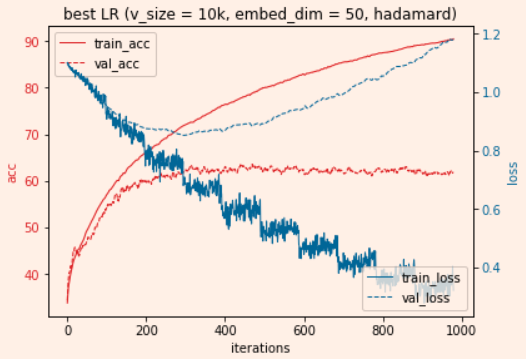

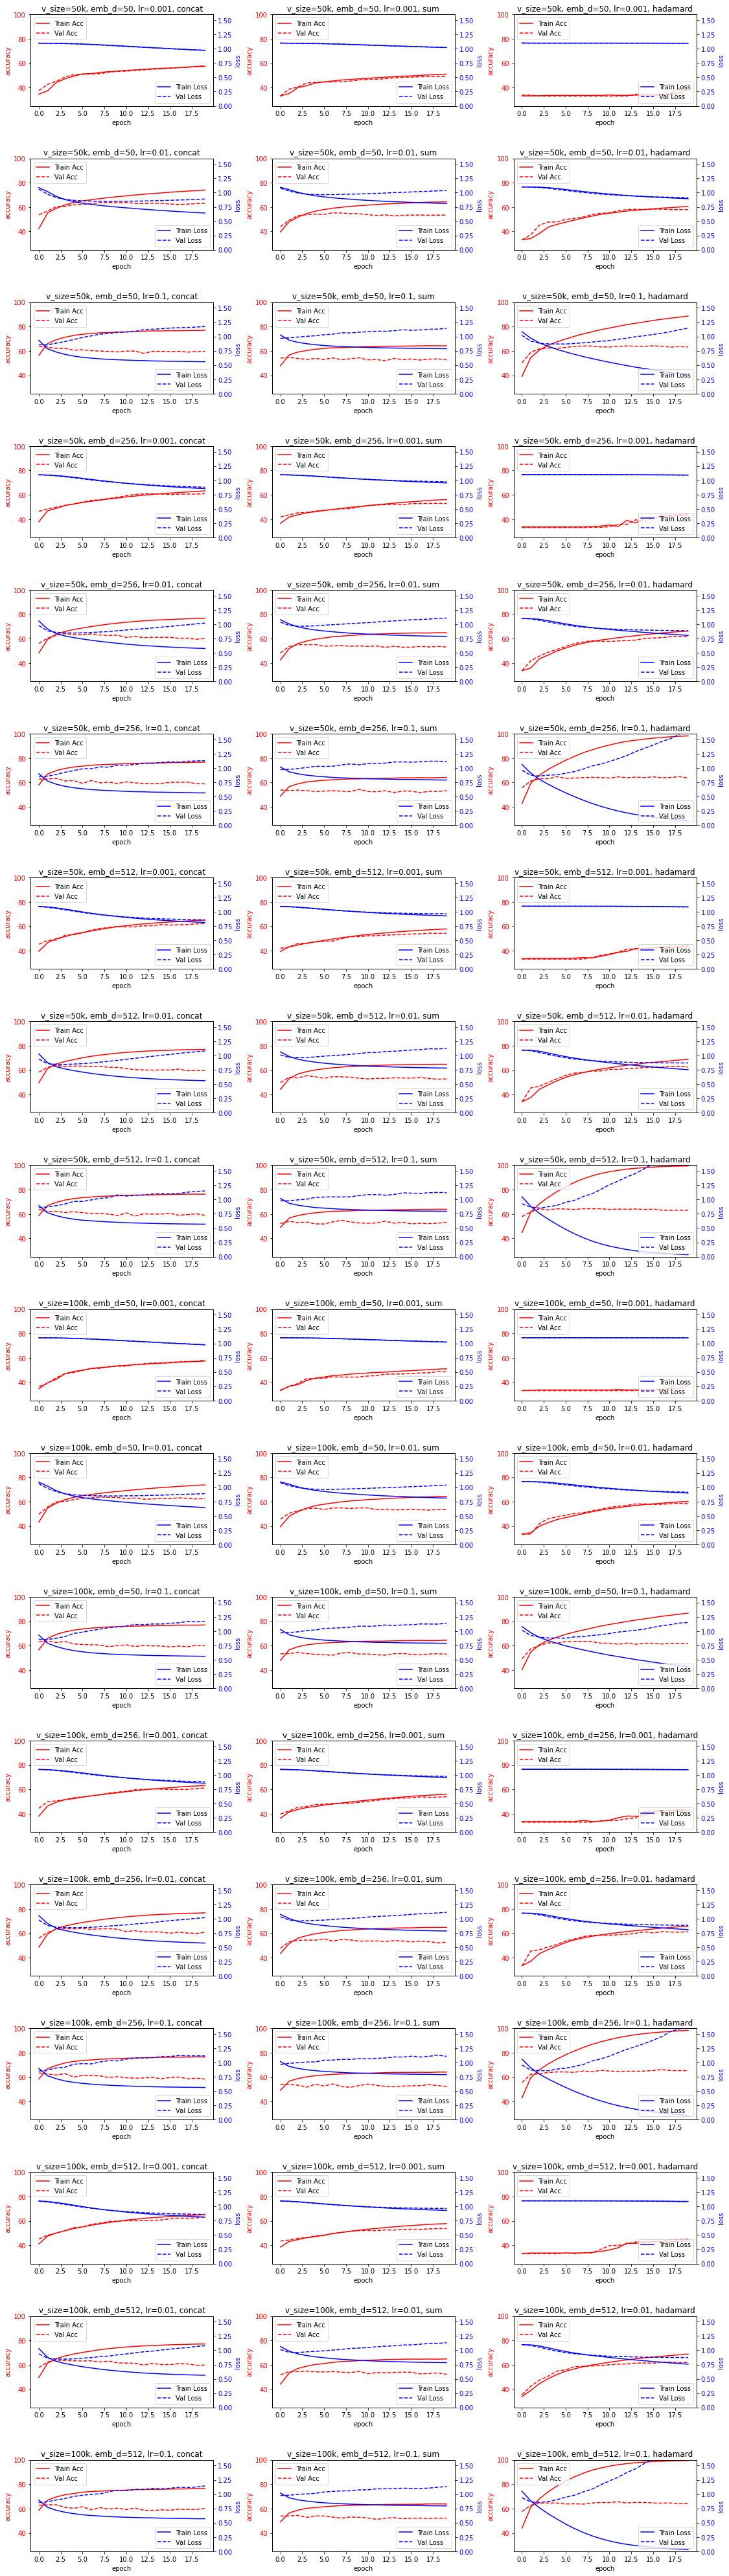

In [ ]:
loss_ax = (0, 1.6)
acc_ax = (25, 100)

# for config in tuning_results:
    # model[1]['train_losses'] + model[1]['val_losses']

fig, axes = plt.subplots(18, 3)
fig.set_figwidth(15)
fig.set_figheight(55)
fig.tight_layout(h_pad=6, w_pad=6)

# for i, config in enumerate(tuning_results):
for config, ax in zip(tuning_results, axes.reshape(-1)): 

    #accuracy

    ax.plot(config[2]['train_accuracies'], 'r')
    ax.plot(config[2]['val_accuracies'], 'r--')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy', color='r')
    ax.set_ylim(acc_ax)
    ax.tick_params(axis='y', labelcolor='r')
    ax.set_title(config[1])
    ax.legend(['Train Acc', 'Val Acc'], loc='upper left')

   
    #loss    
    ax = ax.twinx()
    ax.plot(config[2]['train_losses'], 'b')
    ax.plot(config[2]['val_losses'], 'b--')
    ax.set_ylabel('loss', color='b')
    ax.set_ylim(loss_ax)
    ax.tick_params(axis='y', labelcolor='b')
    ax.legend(['Train Loss', 'Val Loss'], loc='lower right')
    
plt.show()

As seen here, we tuned across vocabulary size (50k, 100k), embedding dimension (50, 100, 200), learning rate (0.001, 0.01, 0.1), and reduce/interaction method (sum, concatenation, hadamard).

With a larger **vocabulary size**, the model may be able to learn more but may be more likely to overfit on unique or uncommon words that wouldn't appear in validation or test data. We found the gap between the training accuracy and validation accuracy to be higher with the larger vocabulary size.

The **learning rate** of 0.1 did better than the other choices examined, for most other hyperparameter configurations. Perhaps the model was not able to train fast enough with smaller learning rates given the limited number of epochs.

The results of the **reduction/interaction technique** (sum, concat, or hadamard) varied with other hyperparameter configurations. However it seems that in many cases, the validation accuracy was able to grow with the training accuracy more closely using hadamard, as compared with the other two methods in which the validation accuracy would often plateau after a few epochs.



**Written 2:** (4 pts)   
Take your best model based on validation performace and report its validation accuracy:

In [ ]:
best_val = 0
best = None
for config in tuning_results:
    if config[2]['val_accuracies'][-1] > best_val:
        best = config[0]
        best_val = max(config[2]['val_accuracies'])

param_string = f"v_size={int(best[0]/1000)}k, emb_d={best[1]}, lr={best[2]}, reduce={best[3]}"
print(f'Validation accuracy of best model: {best_val}%')
print('Parameters:'+ param_string)

Validation accuracy of best model: 66.2%
Parameters:v_size=100k, emb_d=256, lr=0.1, reduce=hadamard


**Written 3:** (4 pts)

Highlight 3 correct and 3 incorrect predictions in this validation set. Describe why the model might have gotten the 3 incorrect predictions wrong.

In [ ]:
# Set params from best model
max_vocab_size = 100000
emb_dim = 256
lr = 0.1
reduce = 'hadamard'
num_epochs = 20

# Build vocab + set up data
token2id, id2token = build_vocab(hypo_data_tokens_train, prem_data_tokens_train, max_vocab_size)
hypo_data_indices_train = token2index(hypo_data_tokens_train, token2id)
prem_data_indices_train = token2index(prem_data_tokens_train, token2id)
hypo_data_indices_val = token2index(hypo_data_tokens_val, token2id)
prem_data_indices_val = token2index(prem_data_tokens_val, token2id)  

train_dataset = NewsGroupDataset(hypo_data_indices_train, prem_data_indices_train, label_index_train, max_sentence_length)
val_dataset = NewsGroupDataset(hypo_data_indices_val, prem_data_indices_val, label_index_val,max_sentence_length)

train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, 
        collate_fn = newsgroup_collate_func, shuffle = True)
val_loader = DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, 
        collate_fn = newsgroup_collate_func, shuffle = True)


In [ ]:
#Train best model one more time
best_val = 0.0
train_losses = [] # record training loss after every epoch
val_losses = [] # record validation loss after every epoch
train_accs = [] # record training accuracy after every epoch
val_accs = [] # record validation accuracy after every epoch

vocab_size = len(id2token)
n_out = len(set(label_index_train))
model = LogisticsModelPytorch(vocab_size, emb_dim, n_out, reduce)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for i, (data_hypo, length_hypo, data_prem, length_prem, labels) in enumerate(train_loader):
        output = model(data_hypo, length_hypo, data_prem, length_prem, reduce)
        loss = criterion(output, labels)
        _, predicted = torch.max(output, 1)
        acc = (predicted == labels.view_as(predicted)).sum().item() / labels.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc
    train_losses.append(epoch_loss / len(train_loader))
    train_accs.append(epoch_acc / len(train_loader) * 100)

    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for i, (data_hypo, length_hypo, data_prem, length_prem, labels) in enumerate(val_loader):
            output = model(data_hypo, length_hypo, data_prem, length_prem, reduce)
            loss = criterion(output, labels)
            _, predicted = torch.max(output, 1)
            acc = (predicted == labels.view_as(predicted)).sum().item() / labels.size(0)
            epoch_loss += loss.item()
            epoch_acc += acc
        val_losses.append(epoch_loss / len(val_loader))
        val_accs.append(epoch_acc / len(val_loader) * 100)            
    if val_accs[-1] > best_val:
        best_val = val_accs[-1]
        torch.save({
            'model_dict': model.state_dict(),
            'epoch': epoch
        }, './model.pt')
    print("[EPOCH]: %i, [TRAIN ACC]: %.3f, [VAL ACC]: %.3f" % (epoch, train_accs[-1], val_accs[-1]))
results = {'train_losses':train_losses,'train_accuracies':train_accs,'val_losses':val_losses,'val_accuracies':val_accs}

[EPOCH]: 0, [TRAIN ACC]: 42.872, [VAL ACC]: 53.700
[EPOCH]: 1, [TRAIN ACC]: 59.269, [VAL ACC]: 60.700
[EPOCH]: 2, [TRAIN ACC]: 66.090, [VAL ACC]: 62.700
[EPOCH]: 3, [TRAIN ACC]: 70.796, [VAL ACC]: 64.700
[EPOCH]: 4, [TRAIN ACC]: 74.964, [VAL ACC]: 64.300
[EPOCH]: 5, [TRAIN ACC]: 78.575, [VAL ACC]: 63.700
[EPOCH]: 6, [TRAIN ACC]: 81.833, [VAL ACC]: 62.900
[EPOCH]: 7, [TRAIN ACC]: 84.803, [VAL ACC]: 64.000
[EPOCH]: 8, [TRAIN ACC]: 87.307, [VAL ACC]: 64.300
[EPOCH]: 9, [TRAIN ACC]: 89.515, [VAL ACC]: 64.900
[EPOCH]: 10, [TRAIN ACC]: 91.254, [VAL ACC]: 64.800
[EPOCH]: 11, [TRAIN ACC]: 92.827, [VAL ACC]: 65.100
[EPOCH]: 12, [TRAIN ACC]: 94.064, [VAL ACC]: 64.400
[EPOCH]: 13, [TRAIN ACC]: 95.092, [VAL ACC]: 64.200
[EPOCH]: 14, [TRAIN ACC]: 95.942, [VAL ACC]: 65.200
[EPOCH]: 15, [TRAIN ACC]: 96.687, [VAL ACC]: 65.300
[EPOCH]: 16, [TRAIN ACC]: 97.275, [VAL ACC]: 64.600
[EPOCH]: 17, [TRAIN ACC]: 97.772, [VAL ACC]: 65.300
[EPOCH]: 18, [TRAIN ACC]: 98.134, [VAL ACC]: 64.200
[EPOCH]: 19, [TRAIN AC

In [ ]:
lbls = {1:'entailment', 2:'contradiction',0:'neutral'}
output = model(data_hypo, length_hypo, data_prem, length_prem, reduce)
_, predicted = torch.max(output, 1)

In [ ]:
# for idx in range(0,10):
for idx in [5,7,12,2,6,8]:
    print(idx)
    print('HYPOTHESIS:', ' '.join([id2token[x] for x in data_hypo[idx][:length_hypo[idx]].tolist()]))
    print('PREMISE:' , ' '.join([id2token[x] for x in data_prem[idx][:length_prem[idx]].tolist()]))
    print('MODEL PREDICTION:', predicted[idx].item(), '=', lbls[predicted[idx].item()])
    print('TRUE LABEL:', labels[idx].item(), '=', lbls[labels[idx].item()], '\n')

5
HYPOTHESIS: a man and a woman stare at the skyline
PREMISE: the man and woman are holding hands
MODEL PREDICTION: 0 = neutral
TRUE LABEL: 0 = neutral 

7
HYPOTHESIS: a boy is posing next to his scooter
PREMISE: a boy is next to a scooter
MODEL PREDICTION: 1 = entailment
TRUE LABEL: 1 = entailment 

12
HYPOTHESIS: a woman rock climbs in a rural area
PREMISE: the woman is in great shape
MODEL PREDICTION: 0 = neutral
TRUE LABEL: 0 = neutral 

2
HYPOTHESIS: a race car speeds away while a man covers his ears
PREMISE: the race car is on a track
MODEL PREDICTION: 2 = contradiction
TRUE LABEL: 0 = neutral 

6
HYPOTHESIS: a child in shorts throws a snowball at a mountain
PREMISE: a boy is playing in the snow without gloves
MODEL PREDICTION: 2 = contradiction
TRUE LABEL: 0 = neutral 

8
HYPOTHESIS: a male bartender dressed in all black with his sleeves rolled up to elbow height making a drink in a
PREMISE: a person in black
MODEL PREDICTION: 0 = neutral
TRUE LABEL: 1 = entailment 



### Why might the model have gotten these wrong?

**2** - The hypothesis includes some action ("speeds away") and man responding negatively ("covers his ears"), which may seem contridictory to the premise which is more limited and factual.

**6** - The model thinks this is a contradiction but the true label is neutral. Perhaps this is due to the premise which indicates the boy is without gloves, which is not referenced in the hypothesis. It's obvious to the human reader that the boy's lack of gloves are not central to the meaning of the sentence.

**8** - The true label is entailment, but the model predicted neutral. I agree with the model here -- the premise includes just one detail "a person in black" while the hypothesis is seeming to describe many more details besides color the person is dressed in, including actions taking place "making a drink." Thus the model's prediction really isn't all that bad here.